In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [3]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import Isomap

In [4]:
data = pd.read_csv(r"heart.csv")

data.drop_duplicates(inplace=True)

In [5]:
categorical_features = ['sex', 'chest pain type', 'fasting blood sugar', 'resting ecg', 'exercise angina', 'ST slope', ]
continuous_features = [ col for col in data.columns.to_list()[1:-1] if col not in categorical_features ]

In [6]:
target = 'target'

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = data[data.columns[:-1]]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.88, random_state=1, shuffle=True, stratify=y)

preprocessor = ColumnTransformer(
                    transformers=[
                        ('cat', OneHotEncoder(), categorical_features),
                        ('num', StandardScaler(), continuous_features)
                    ]
                )

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# X = preprocessor.fit_transform(X)

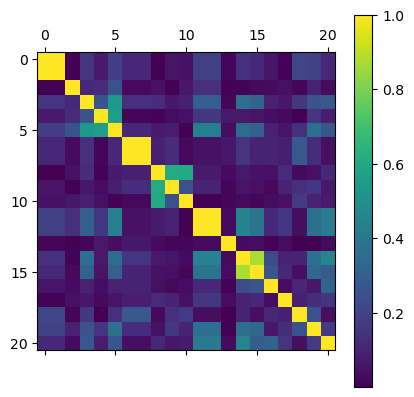

In [8]:
plt.matshow(pd.DataFrame(X_train).corr().abs())
plt.colorbar()
plt.show()

In [9]:
def nullify_values(df):
    n = df.shape[0]  # Assuming equal number of rows and columns
    for i in range(n):
        if i % 3 == 0:
            cols_to_keep = [i, (i + 1) % n, (i + 2) % n]  # Use modulo to handle wrap-around
            df.iloc[i, ~df.columns.isin(df.columns[cols_to_keep])] = False
        else:
            df.iloc[i, :] = False
    return df

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, pairwise_distances

In [12]:
def dunn_index(_X, labels):
    distances = pairwise_distances(_X)
    unique_labels = np.unique(labels)
    
    inter_cluster_distances = []
    intra_cluster_distances = []
    
    for i in unique_labels:
        cluster_i = _X[labels == i]
        intra_cluster_distances.append(np.mean(pairwise_distances(cluster_i)))
        
        for j in unique_labels:
            if i < j:
                cluster_j = _X[labels == j]
                inter_cluster_distances.append(np.min(pairwise_distances(cluster_i, cluster_j)))
                
    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

In [13]:
kmeans_evals = ['Inertia'] + ['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'] # + ['ari', 'nmi', 'fowlkes_mallows']

gmm_evals = ['Log-Likelihood', 'AIC', 'BIC'] + ['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'] # + ['ari', 'nmi', 'fowlkes_mallows']

In [14]:
def dict2data(nested_dict, k1, k2, k3):
    flat_data = []

    for key1, sub_dict1 in nested_dict.items():
        for key2, sub_dict2 in sub_dict1.items():
            for key3, metrics in sub_dict2.items():
                flat_entry = {k1: key1, k2: key2, k3: key3}
                flat_entry.update(metrics)
                flat_data.append(flat_entry)

    _df = pd.DataFrame(flat_data)
    return _df

In [51]:
evals= {}
model_data = {}

evals['kmeans'] = {}
model_data['kmeans'] = {}

for iters in [300, 500]:
    
    evals['kmeans'][iters] = {}
    model_data['kmeans'][iters] = {}
    
    for tol in [1e-2, 1e-4, 1e-6]:
    
        evals['kmeans'][iters][tol] = {}
        model_data['kmeans'][iters][tol] = {}
        
        for k in range(2, 5+1):
            kmeans = KMeans(n_clusters=k, tol=tol, max_iter=500)
            kmeans.fit(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
            kmeans_labels = kmeans.labels_
            
            # Inertia (Within-Cluster Sum of Squares)
            inertia = kmeans.inertia_
            
            # Silhouette Score
            silhouette = silhouette_score(X_train, kmeans_labels)
            
            # Davies-Bouldin Index
            davies_bouldin = davies_bouldin_score(X_train, kmeans_labels)
            
            # Dunn Index
            dunn = dunn_index(X_train, kmeans_labels)
            
            # # Comparison with ground truth
            ari = adjusted_rand_score(y_train, kmeans_labels)
            nmi = normalized_mutual_info_score(y_train, kmeans_labels)
            fmi = fowlkes_mallows_score(y_train, kmeans_labels)
        
            evals['kmeans'][iters][tol][k] = dict.fromkeys(kmeans_evals, 0)
        
            evals['kmeans'][iters][tol][k]['Inertia'] = inertia
            evals['kmeans'][iters][tol][k]['Silhouette Score'] = silhouette
            evals['kmeans'][iters][tol][k]['Davies-Bouldin Index'] = davies_bouldin
            evals['kmeans'][iters][tol][k]['Dunn Index'] = dunn
            evals['kmeans'][iters][tol][k]['ARI'] = ari
            evals['kmeans'][iters][tol][k]['NMI'] = nmi
            evals['kmeans'][iters][tol][k]['FMI'] = fmi
        
            model_data['kmeans'][iters][tol][k] = {}
            model_data['kmeans'][iters][tol][k]['labels'] = kmeans_labels
            model_data['kmeans'][iters][tol][k]['centers'] = kmeans.cluster_centers_
            model_data['kmeans'][iters][tol][k]['n_iters'] = kmeans.n_iter_
            model_data['kmeans'][iters][tol][k]['feature_names'] = kmeans.feature_names_in_

In [52]:
evals['kmeans']

{300: {0.01: {2: {'Inertia': 4488.852731000407,
    'Silhouette Score': 0.18886947693165743,
    'Davies-Bouldin Index': 1.9639597379303024,
    'Dunn Index': 0.21603102013906267,
    'ARI': 0.4192920001924954,
    'NMI': 0.34067660657691823,
    'FMI': 0.7110416232737616},
   3: {'Inertia': 3893.151964972922,
    'Silhouette Score': 0.20392488481215582,
    'Davies-Bouldin Index': 1.7614757697487855,
    'Dunn Index': 0.12880778642832424,
    'ARI': 0.3337437205167901,
    'NMI': 0.30568428063579717,
    'FMI': 0.6243138323040021},
   4: {'Inertia': 3689.8118806772272,
    'Silhouette Score': 0.14504062336187631,
    'Davies-Bouldin Index': 2.1119026122976488,
    'Dunn Index': 0.05684559105740185,
    'ARI': 0.27285630012701506,
    'NMI': 0.2751621718675295,
    'FMI': 0.5547245360461096},
   5: {'Inertia': 3510.859634592648,
    'Silhouette Score': 0.10987540710037272,
    'Davies-Bouldin Index': 2.2601980630467535,
    'Dunn Index': 0.07571565593610188,
    'ARI': 0.17396758263973

In [53]:
kmeans_evals_df = dict2data(evals['kmeans'], 'iters', 'tol', 'clusters')
# kmeans_evals_df
kmeans_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,iters,tol,clusters,Inertia,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
0,300,0.010000,2,4488.852731,0.188869,1.963960,0.216031,0.419292,0.340677,0.711042
1,300,0.010000,3,3893.151965,0.203925,1.761476,0.128808,0.333744,0.305684,0.624314
2,300,0.010000,4,3689.811881,0.145041,2.111903,0.056846,0.272856,0.275162,0.554725
3,300,0.010000,5,3510.859635,0.109875,2.260198,0.075716,0.173968,0.210932,0.457214
4,300,0.000100,2,4488.751389,0.188869,1.963960,0.216031,0.419292,0.340677,0.711042
5,300,0.000100,3,3892.909096,0.204229,1.756603,0.128925,0.333726,0.306587,0.624710
6,300,0.000100,4,3714.202176,0.151831,2.178374,0.219073,0.312992,0.299464,0.583809
7,300,0.000100,5,3514.861631,0.130039,2.089093,0.067188,0.205531,0.225522,0.492649
8,300,0.000001,2,4488.751389,0.188869,1.963960,0.216031,0.419292,0.340677,0.711042
9,300,0.000001,3,3892.869951,0.204550,1.753586,0.129585,0.339101,0.311927,0.628059


In [54]:
kmeans_evals_df.query('(iters == 300) & (tol == 0.0001)')[['tol', 'clusters', 'Inertia', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})

,tol,clusters,Inertia,Silhouette,Davies-Bouldin,Dunn
4,0.0001,2,4488.751389,0.188869,1.963960,0.216031
5,0.0001,3,3892.909096,0.204229,1.756603,0.128925
6,0.0001,4,3714.202176,0.151831,2.178374,0.219073
7,0.0001,5,3514.861631,0.130039,2.089093,0.067188


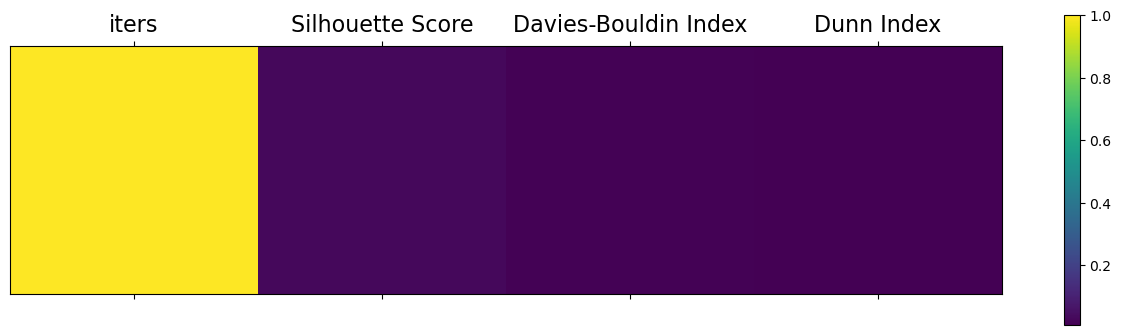

In [55]:
plt.matshow(kmeans_evals_df[['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

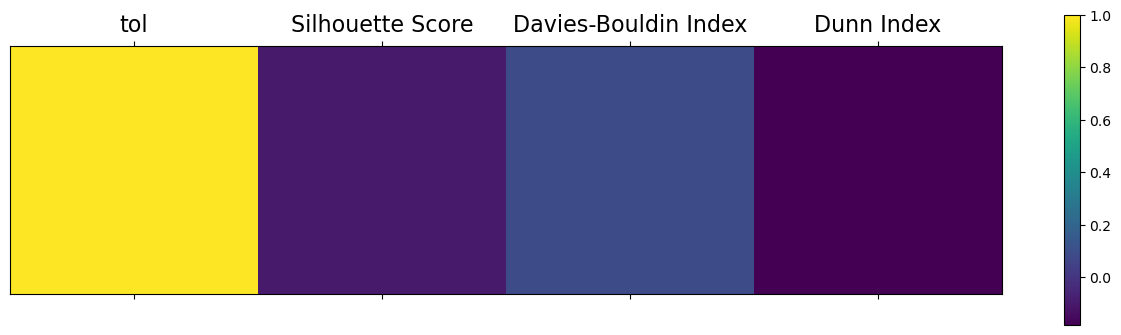

In [56]:
plt.matshow(kmeans_evals_df[['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

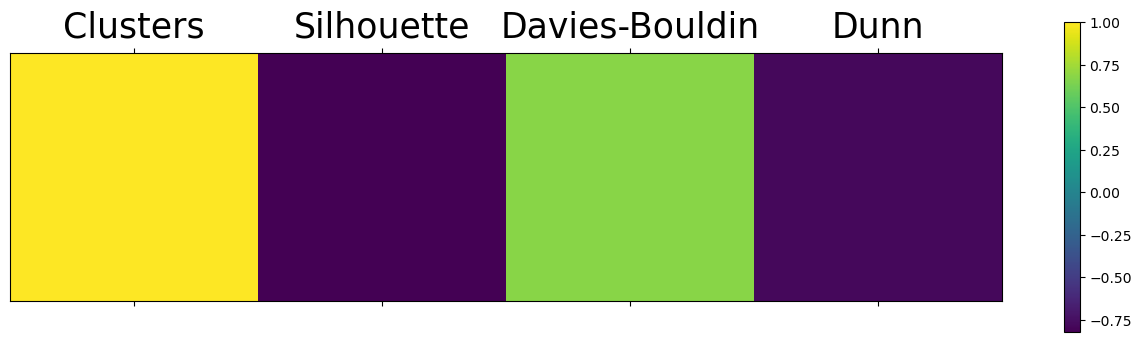

In [57]:
# plt.figure(figsize=(8, 2))
plt.matshow(kmeans_evals_df[['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['Clusters', 'Silhouette', 'Davies-Bouldin', 'Dunn'], fontsize=25)
plt.yticks([])
plt.show()

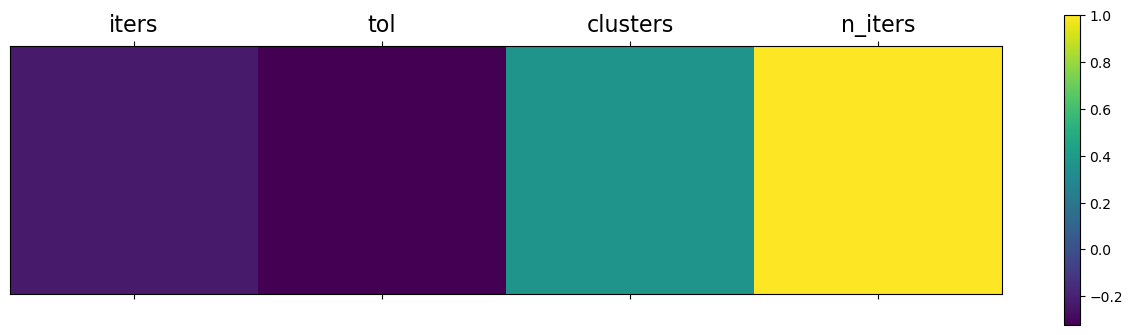

In [58]:
plt.matshow(dict2data(model_data['kmeans'], 'iters', 'tol', 'clusters')[['iters', 'tol', 'clusters', 'n_iters']].corr().iloc[[3]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'tol', 'clusters', 'n_iters'], fontsize=16)
plt.yticks([])
plt.show()

In [63]:
evals['gmm'] = {}
model_data['gmm'] = {}

for iters in [100, 250]:
    
    evals['gmm'][iters] = {}
    model_data['gmm'][iters] = {}
    
    for tol in [1e-2, 1e-3, 1e-4]:
    
        evals['gmm'][iters][tol] = {}
        model_data['gmm'][iters][tol] = {}
        
        for k in range(2, 5+1):
            gmm = GaussianMixture(n_components=k, )
            gmm.fit(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
            gmm_labels = gmm.predict(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
            
            # Log-Likelihood
            log_likelihood = gmm.score(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
            
            # BIC and AIC
            bic = gmm.bic(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
            aic = gmm.aic(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
            
            # Silhouette Score
            silhouette = silhouette_score(X_train, gmm_labels)
            
            # Davies-Bouldin Index
            davies_bouldin = davies_bouldin_score(X_train, gmm_labels)
            
            # Dunn Index
            dunn = dunn_index(X_train, gmm_labels)
            
            # # Comparison with ground truth
            ari = adjusted_rand_score(y_train, gmm_labels)
            nmi = normalized_mutual_info_score(y_train, gmm_labels)
            fmi = fowlkes_mallows_score(y_train, gmm_labels)
        
            evals['gmm'][iters][tol][k] = dict.fromkeys(gmm_evals, 0)
            
            evals['gmm'][iters][tol][k]['Log-Likelihood'] = log_likelihood
            evals['gmm'][iters][tol][k]['AIC'] = aic
            evals['gmm'][iters][tol][k]['BIC'] = bic
            evals['gmm'][iters][tol][k]['Silhouette Score'] = silhouette
            evals['gmm'][iters][tol][k]['Davies-Bouldin Index'] = davies_bouldin
            evals['gmm'][iters][tol][k]['Dunn Index'] = dunn
            evals['gmm'][iters][tol][k]['ARI'] = ari
            evals['gmm'][iters][tol][k]['NMI'] = nmi
            evals['gmm'][iters][tol][k]['FMI'] = fmi
        
            model_data['gmm'][iters][tol][k] = {}
            model_data['gmm'][iters][tol][k]['labels'] = gmm_labels
            model_data['gmm'][iters][tol][k]['centers'] = gmm.means_
            model_data['gmm'][iters][tol][k]['n_iters'] = gmm.n_iter_
            model_data['gmm'][iters][tol][k]['feature_names'] = gmm.feature_names_in_

In [64]:
evals['gmm']

{100: {0.01: {2: {'Log-Likelihood': 34.680985906903516,
    'AIC': -54965.111253742274,
    'BIC': -52594.98280126595,
    'Silhouette Score': 0.10912556390898741,
    'Davies-Bouldin Index': 2.733773954639331,
    'Dunn Index': 0.40642756081802434,
    'ARI': 0.26600705499354277,
    'NMI': 0.19794535108664016,
    'FMI': 0.6371234723982853},
   3: {'Log-Likelihood': 34.11377962769436,
    'AIC': -53543.640319098704,
    'BIC': -49986.10097855008,
    'Silhouette Score': 0.1752028399768127,
    'Davies-Bouldin Index': 1.9292725296787365,
    'Dunn Index': 0.22506705528344403,
    'ARI': 0.2971565501424081,
    'NMI': 0.27647152453354296,
    'FMI': 0.6059051817429099},
   4: {'Log-Likelihood': 45.98974110353386,
    'AIC': -72205.44214110365,
    'BIC': -67460.49191248273,
    'Silhouette Score': 0.0998382986060866,
    'Davies-Bouldin Index': 2.6901621425781777,
    'Dunn Index': 0.26707853317261,
    'ARI': 0.17049779452134436,
    'NMI': 0.18005691185673883,
    'FMI': 0.5204744789

In [65]:
gmm_evals_df = dict2data(evals['gmm'], 'iters', 'tol', 'clusters')

gmm_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,iters,tol,clusters,Log-Likelihood,AIC,BIC,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
0,100,0.010000,2,34.680986,-54965.111254,-52594.982801,0.109126,2.733774,0.406428,0.266007,0.197945,0.637123
1,100,0.010000,3,34.113780,-53543.640319,-49986.100979,0.175203,1.929273,0.225067,0.297157,0.276472,0.605905
2,100,0.010000,4,45.989741,-72205.442141,-67460.491912,0.099838,2.690162,0.267079,0.170498,0.180057,0.520474
3,100,0.010000,5,48.713621,-76095.783918,-70163.422801,0.076319,3.160449,0.284182,0.204025,0.211091,0.499922
4,100,0.001000,2,34.680986,-54965.111254,-52594.982801,0.109126,2.733774,0.406428,0.266007,0.197945,0.637123
5,100,0.001000,3,35.033913,-55028.735444,-51471.196104,0.172860,1.938309,0.226235,0.286737,0.267012,0.601189
6,100,0.001000,4,47.097527,-73993.409109,-69248.458880,0.096667,3.022438,0.264578,0.166156,0.180291,0.512038
7,100,0.001000,5,49.625328,-77567.280077,-71634.918960,0.090313,2.648364,0.273685,0.211240,0.255261,0.504814
8,100,0.000100,2,34.680986,-54965.111254,-52594.982801,0.109126,2.733774,0.406428,0.266007,0.197945,0.637123
9,100,0.000100,3,35.033913,-55028.735444,-51471.196104,0.172860,1.938309,0.226235,0.286737,0.267012,0.601189


In [66]:
gmm_evals_df.query('(iters == 100) & (tol == 0.001)')[['tol', 'clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})

,tol,clusters,Silhouette,Davies-Bouldin,Dunn
4,0.001,2,0.109126,2.733774,0.406428
5,0.001,3,0.172860,1.938309,0.226235
6,0.001,4,0.096667,3.022438,0.264578
7,0.001,5,0.090313,2.648364,0.273685


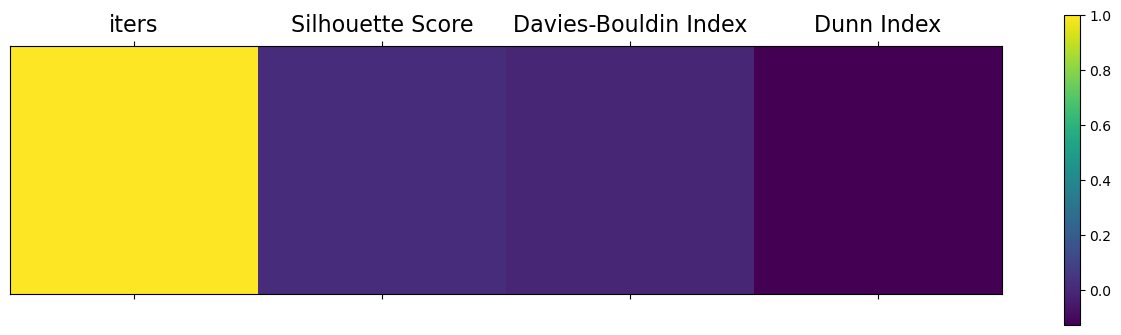

In [67]:
plt.matshow(gmm_evals_df[['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

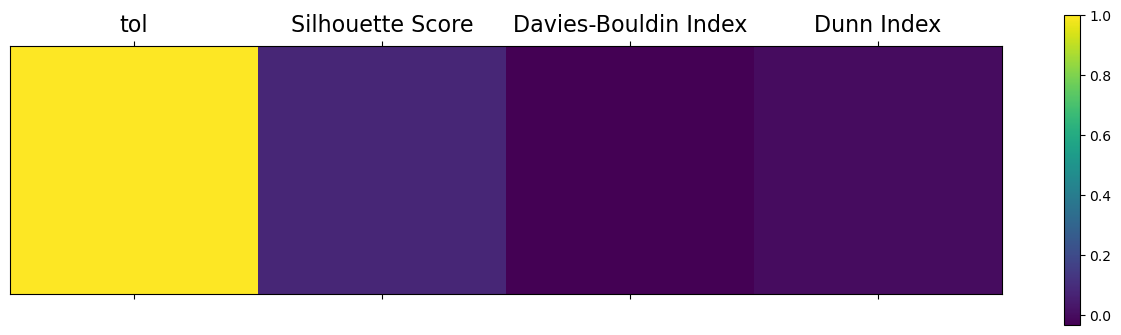

In [68]:
plt.matshow(gmm_evals_df[['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['tol', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

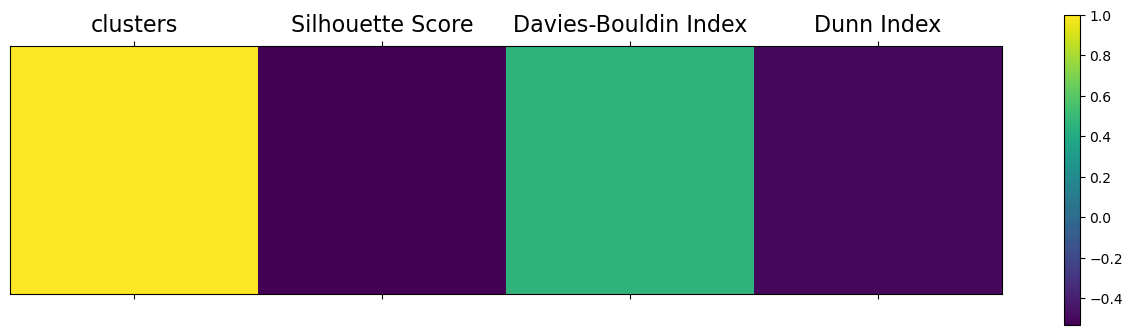

In [69]:
plt.matshow(gmm_evals_df[['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].corr().iloc[[0]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['clusters', 'Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index'], fontsize=16)
plt.yticks([])
plt.show()

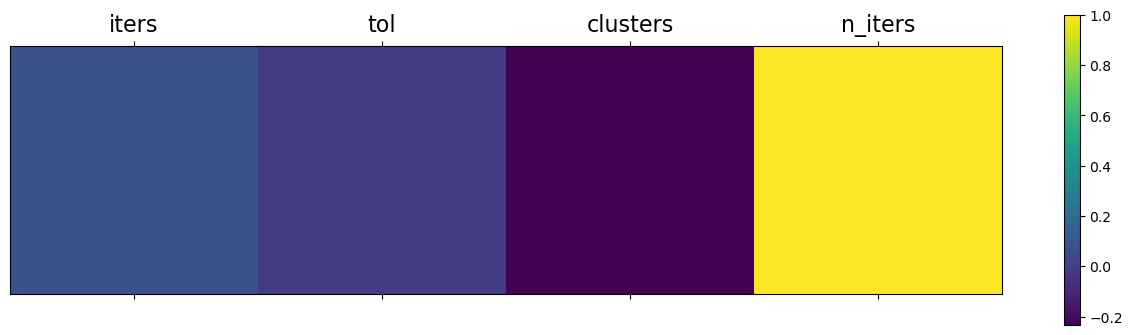

In [70]:
plt.matshow(dict2data(model_data['gmm'], 'iters', 'tol', 'clusters')[['iters', 'tol', 'clusters', 'n_iters']].corr().iloc[[3]])
plt.colorbar()
plt.xticks([0,1,2,3,], ['iters', 'tol', 'clusters', 'n_iters'], fontsize=16)
plt.yticks([])
plt.show()

### Dimnsionality Reduction

In [77]:
import time

dim_red_times = {}

In [78]:
# Fit PCA
pca = PCA().fit(X_train)

# Explained variance
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

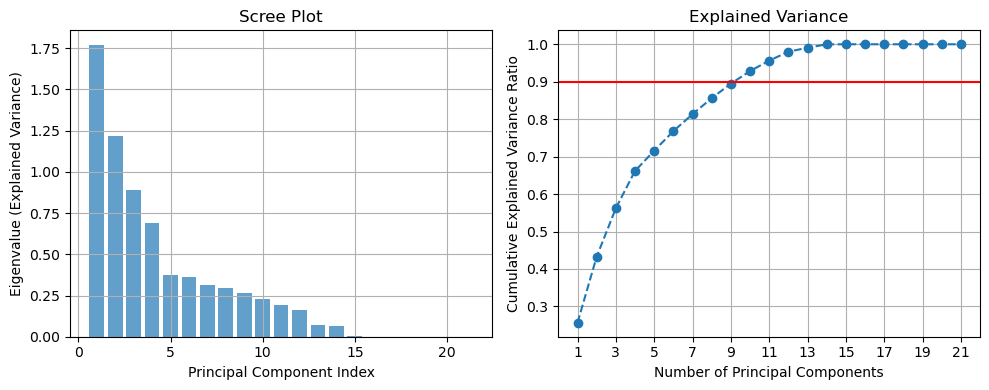

In [82]:
# Plot explained variance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Individual explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Eigenvalue (Explained Variance)')
plt.title('Scree Plot')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, X_train.shape[1]+1, 2), range(1, X_train.shape[1]+1, 2))
plt.title('Explained Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

In [83]:
pca_nc = 9
pca = PCA(n_components=pca_nc, )

st = time.time()
X_train_pca = pca.fit_transform(X_train)
dim_red_times['pca'] = time.time() - st

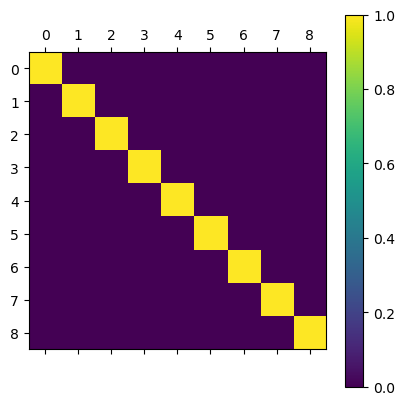

In [84]:
plt.matshow(pd.DataFrame(X_train_pca).corr().abs())
plt.colorbar()
plt.show()

In [85]:
from scipy.stats import kurtosis
import warnings
from sklearn.exceptions import ConvergenceWarning

# Function to compute kurtosis for ICA components
def compute_kurtosis(_X, n_components):
    tol = 0.0000001
    max_iter = 1000000
    
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always", ConvergenceWarning)

        while True:
            ica = FastICA(n_components=n_components, tol=tol, max_iter=max_iter, whiten_solver='eigh', random_state=42)
            st = time.time()
            X_ica = ica.fit_transform(_X)
            tt = time.time() - st
            
            # Check if any ConvergenceWarning was raised
            if not any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                print(f"{n_components} Components: Converged with tol={tol}, max_iter={max_iter}.")
                break
            else:
                print(f"{n_components} Components: ConvergenceWarning detected with tol={tol}, max_iter={max_iter}. Retrying...")

                if max_iter == 100000 and tol > 0.001:
                    max_iter = max_iter * 10
                else:
                    max_iter = 100000

                    if tol == 0.00001:
                        tol = tol* 100
                    elif tol < 0.1:
                        tol = tol * 10
                    elif tol == 0.1:
                        tol = 0.5
                    elif tol == 0.5:
                        tol = 1
                    else:
                        tol += 1
    
    # ica = FastICA(n_components=n_components, tol=0.5, max_iter=100000)
    # X_ica = ica.fit_transform(_X)
    kurt_values = kurtosis(X_ica, fisher=False)
    avg_kurtosis = np.mean(np.abs(kurt_values))
    return ica, X_ica, kurt_values, avg_kurtosis, tt

1 Components: Converged with tol=1e-07, max_iter=1000000.
2 Components: Converged with tol=1e-07, max_iter=1000000.
3 Components: Converged with tol=1e-07, max_iter=1000000.
4 Components: Converged with tol=1e-07, max_iter=1000000.
5 Components: Converged with tol=1e-07, max_iter=1000000.
6 Components: Converged with tol=1e-07, max_iter=1000000.
7 Components: Converged with tol=1e-07, max_iter=1000000.
8 Components: Converged with tol=1e-07, max_iter=1000000.
9 Components: Converged with tol=1e-07, max_iter=1000000.
10 Components: Converged with tol=1e-07, max_iter=1000000.
11 Components: Converged with tol=1e-07, max_iter=1000000.
12 Components: Converged with tol=1e-07, max_iter=1000000.
13 Components: Converged with tol=1e-07, max_iter=1000000.
14 Components: Converged with tol=1e-07, max_iter=1000000.
15 Components: Converged with tol=1e-07, max_iter=1000000.
16 Components: Converged with tol=1e-07, max_iter=1000000.
17 Components: Converged with tol=1e-07, max_iter=1000000.
18 Com

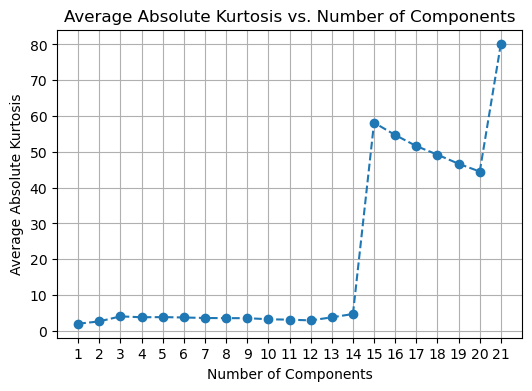

In [86]:
# Evaluate different numbers of components
components_range = range(1, X_train.shape[1]+1)
avg_kurtosis_values = []

for n in components_range:
    ica_model, ica_X, _, avg_kurt, tt = compute_kurtosis(X_train, n)
    avg_kurtosis_values.append(avg_kurt)

# Plot average kurtosis values
plt.figure(figsize=(6, 4))
plt.plot(components_range, avg_kurtosis_values, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Average Absolute Kurtosis')
plt.title('Average Absolute Kurtosis vs. Number of Components')
plt.xticks(range(1, X_train.shape[1]+1))
plt.grid(True)
plt.show()

In [87]:
ica_nc = 15
ica, X_train_ica, kurt_values, avg_kurt, tt = compute_kurtosis(X_train, ica_nc)
print(f"Kurtosis values for {ica_nc} components:")
print(kurt_values)
print(f"Average Absolute Kurtosis for {ica_nc} components: {avg_kurt:.4f}")

15 Components: Converged with tol=1e-07, max_iter=1000000.
Kurtosis values for 15 components:
[  5.2984263    1.22180355   2.50496945   4.36633263 804.91880302
   2.64864254   1.87720916  13.50583932   3.7756522    1.33671776
   3.30240518   1.30956419  17.11281181   4.76819724   4.19628618]
Average Absolute Kurtosis for 15 components: 58.1429


In [88]:
top_ica_components = np.argsort(np.abs(kurt_values))[-5:]  # Select top 5 components by absolute kurtosis

In [89]:
kurt_values

array([  5.2984263 ,   1.22180355,   2.50496945,   4.36633263,
       804.91880302,   2.64864254,   1.87720916,  13.50583932,
         3.7756522 ,   1.33671776,   3.30240518,   1.30956419,
        17.11281181,   4.76819724,   4.19628618])

In [90]:
# Fit ICA and project on top components
X_train_ica_selected = X_train_ica[:, list(reversed(top_ica_components.tolist()))]

print(f"Selected top components based on kurtosis: {top_ica_components}")

Selected top components based on kurtosis: [13  0  7 12  4]


In [91]:
dim_red_times['ica'] = tt

In [67]:
# ica_nc = 21
# ica, X_train_ica, kurt_values, avg_kurt = compute_kurtosis(X_train, ica_nc)
# print(f"Kurtosis values for {ica_nc} components:")
# print(kurt_values)
# print(f"Average Absolute Kurtosis for {ica_nc} components: {avg_kurt:.4f}")

# top_ica_components = np.argsort(np.abs(kurt_values))[-int((ica_nc+1)/2):]  # Select top 5 components by absolute kurtosis

In [68]:
# st = time.time()
# FastICA(n_components=15, tol=0.0001, max_iter=100000).fit_transform(X_train)
# dim_red_times['ica'] = time.time() - st
# print(dim_red_times['ica'])

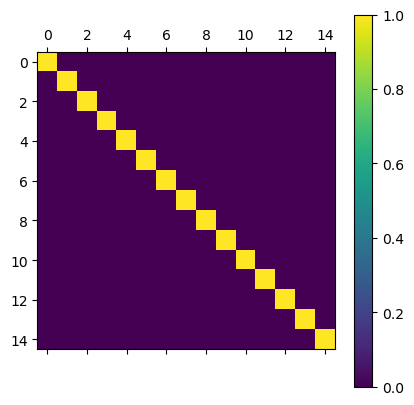

In [92]:
plt.matshow(pd.DataFrame(X_train_ica).corr().abs())
plt.colorbar()
plt.show()

In [93]:
from sklearn.metrics import mean_squared_error

def compute_reconstruction_error(_X, n_components):
    rp = GaussianRandomProjection(n_components=n_components, )
    X_rp_projected = rp.fit_transform(_X)
    W = rp.components_  # Projection matrix
    W_pseudo_inverse = np.linalg.pinv(W)  # Pseudo inverse of the projection matrix
    X_rp_reconstructed = X_rp_projected @ W_pseudo_inverse.T  # Reconstruct the data
    reconstruction_error = mean_squared_error(_X, X_rp_reconstructed)
    return reconstruction_error

In [94]:
# Evaluate different numbers of components
reconstruction_errors = []

for n in components_range:
    recon_error = compute_reconstruction_error(X_train, n)
    reconstruction_errors.append(recon_error)

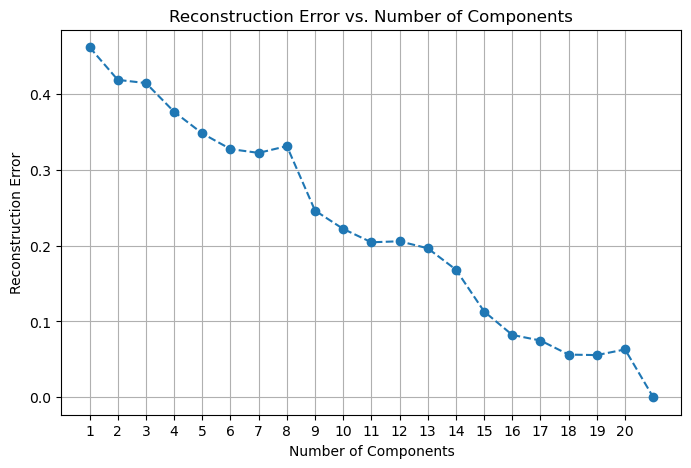

In [100]:
# Plot reconstruction errors
plt.figure(figsize=(8, 5))
plt.plot(components_range, reconstruction_errors, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Components')
plt.grid(True)
plt.xticks(range(1, X_train.shape[1]))
plt.show()

In [103]:
rp_nc = 15

rp = GaussianRandomProjection(n_components=rp_nc, )
st = time.time()
X_train_rp = rp.fit_transform(X_train)
dim_red_times['rp'] = time.time() - st

W = rp.components_  # Projection matrix
W_pseudo_inverse = np.linalg.pinv(W)  # Pseudo inverse of the projection matrix
X_train_rp_reconstructed = X_train_rp @ W_pseudo_inverse.T  # Reconstruct the data
reconstruction_error = mean_squared_error(X_train, X_train_rp_reconstructed)
print(reconstruction_error)

0.11392482475539976


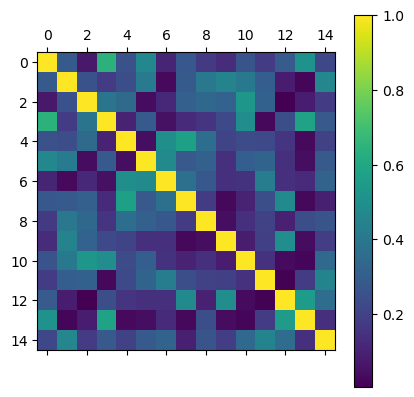

In [104]:
plt.matshow(pd.DataFrame(X_train_rp).corr().abs())
plt.colorbar()
plt.show()

In [105]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

def compute_residual_variance(_X, n_components):
    isomap = Isomap(n_components=n_components)
    X_isomap = isomap.fit_transform(_X)
    
    # Compute pairwise distances
    D_original = pairwise_distances(_X)
    D_isomap = pairwise_distances(X_isomap)
    
    # Compute squared correlation coefficient (R^2)
    D_original_flat = D_original.flatten()
    D_isomap_flat = D_isomap.flatten()
    correlation_matrix = np.corrcoef(D_original_flat, D_isomap_flat)
    R2 = correlation_matrix[0, 1] ** 2
    
    # Residual variance
    residual_variance = 1 - R2
    return residual_variance

In [106]:
# Evaluate different numbers of components
residual_variances = []

for n in components_range:
    residual_variance = compute_residual_variance(X_train, n)
    residual_variances.append(residual_variance)

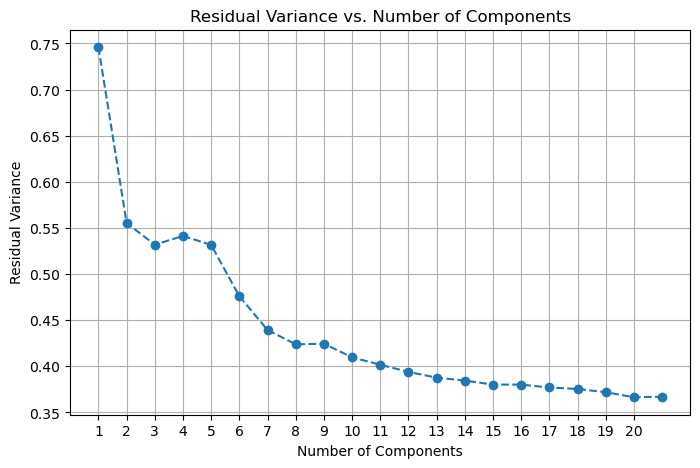

In [108]:
# Plot residual variances
plt.figure(figsize=(8, 5))
plt.plot(components_range, residual_variances, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Residual Variance')
plt.title('Residual Variance vs. Number of Components')
plt.grid(True)
plt.xticks(range(1, X_train.shape[1]))
plt.show()

In [109]:
isomap_nc = 8

isomap = Isomap(n_components=isomap_nc)

st = time.time()
X_train_isomap = isomap.fit_transform(X_train)
dim_red_times['isomap'] = time.time() - st

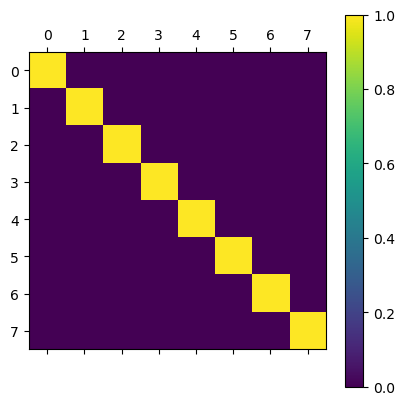

In [45]:
plt.matshow(pd.DataFrame(X_train_isomap).corr().abs())
plt.colorbar()
plt.show()

In [110]:
cluster_times = {}

cluster_times['kmeans'] = {}
cluster_times['gmm'] = {}

In [111]:
# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, )
st = time.time()
gmm.fit(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
cluster_times['gmm']['baseline'] = time.time() - st
gmm_labels = gmm.predict(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))

# Fit KMeans
kmeans = KMeans(n_clusters=3, )
st = time.time()
kmeans.fit(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
cluster_times['kmeans']['baseline'] = time.time() - st
kmeans_labels = kmeans.predict(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))

In [112]:
# Fit Gaussian Mixture Model
gmm_pca = GaussianMixture(n_components=3, )
st = time.time()
gmm_pca.fit(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
cluster_times['gmm']['pca'] = time.time() - st
gmm_pca_labels = gmm_pca.predict(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))

# Fit KMeans
kmeans_pca = KMeans(n_clusters=3, )
st = time.time()
kmeans_pca.fit(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
cluster_times['kmeans']['pca'] = time.time() - st
kmeans_pca_labels = kmeans_pca.predict(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))

In [113]:
# Fit Gaussian Mixture Model
gmm_ica = GaussianMixture(n_components=3, )
st = time.time()
gmm_ica.fit(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
cluster_times['gmm']['ica'] = time.time() - st
gmm_ica_labels = gmm_ica.predict(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))

# Fit KMeans
kmeans_ica = KMeans(n_clusters=3, )
st = time.time()
kmeans_ica.fit(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
cluster_times['kmeans']['ica'] = time.time() - st
kmeans_ica_labels = kmeans_ica.predict(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))

In [115]:
# Fit Gaussian Mixture Model
gmm_rp = GaussianMixture(n_components=3, )
st = time.time()
gmm_rp.fit(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
cluster_times['gmm']['rp'] = time.time() - st
gmm_rp_labels = gmm_rp.predict(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))

# Fit KMeans
kmeans_rp = KMeans(n_clusters=3, )
st = time.time()
kmeans_rp.fit(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
cluster_times['kmeans']['rp'] = time.time() - st
kmeans_rp_labels = kmeans_rp.predict(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))

In [116]:
# Fit Gaussian Mixture Model
gmm_isomap = GaussianMixture(n_components=3, )
st = time.time()
gmm_isomap.fit(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
cluster_times['gmm']['isomap'] = time.time() - st
gmm_isomap_labels = gmm_isomap.predict(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))

# Fit KMeans
kmeans_isomap = KMeans(n_clusters=3, )
st = time.time()
kmeans_isomap.fit(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
cluster_times['kmeans']['isomap'] = time.time() - st
kmeans_isomap_labels = kmeans_isomap.predict(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))

In [117]:
red_clustering_evals = {}

red_clustering_model_data = {}

In [118]:
red_clustering_evals['kmeans'] = {}
red_clustering_model_data['kmeans'] = {}

In [119]:
red_clustering_evals['kmeans']['baseline'] = {}
red_clustering_model_data['kmeans']['baseline'] = {}

red_clustering_evals['kmeans']['baseline']['Inertia'] = kmeans.inertia_
red_clustering_evals['kmeans']['baseline']['Silhouette Score'] = silhouette_score(X_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['Davies-Bouldin Index'] = davies_bouldin_score(X_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['Dunn Index'] = dunn_index(X_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['ARI'] = adjusted_rand_score(y_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['NMI'] = normalized_mutual_info_score(y_train, kmeans_labels)
red_clustering_evals['kmeans']['baseline']['FMI'] = fowlkes_mallows_score(y_train, kmeans_labels)

red_clustering_model_data['kmeans']['baseline'] = {}
red_clustering_model_data['kmeans']['baseline']['labels'] = kmeans_labels
red_clustering_model_data['kmeans']['baseline']['centers'] = kmeans.cluster_centers_
red_clustering_model_data['kmeans']['baseline']['n_iters'] = kmeans.n_iter_
red_clustering_model_data['kmeans']['baseline']['feature_names'] = kmeans.feature_names_in_

In [120]:
red_clustering_evals['kmeans']['pca'] = {}
red_clustering_model_data['kmeans']['pca'] = {}

red_clustering_evals['kmeans']['pca']['Inertia'] = kmeans_pca.inertia_
red_clustering_evals['kmeans']['pca']['Silhouette Score'] = silhouette_score(X_train_pca, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_pca, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['Dunn Index'] = dunn_index(X_train_pca, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['ARI'] = adjusted_rand_score(y_train, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['NMI'] = normalized_mutual_info_score(y_train, kmeans_pca_labels)
red_clustering_evals['kmeans']['pca']['FMI'] = fowlkes_mallows_score(y_train, kmeans_pca_labels)

red_clustering_model_data['kmeans']['pca'] = {}
red_clustering_model_data['kmeans']['pca']['labels'] = kmeans_pca_labels
red_clustering_model_data['kmeans']['pca']['centers'] = kmeans_pca.cluster_centers_
red_clustering_model_data['kmeans']['pca']['n_iters'] = kmeans_pca.n_iter_
red_clustering_model_data['kmeans']['pca']['feature_names'] = kmeans_pca.feature_names_in_

In [121]:
red_clustering_evals['kmeans']['ica'] = {}
red_clustering_model_data['kmeans']['ica'] = {}

red_clustering_evals['kmeans']['ica']['Inertia'] = kmeans_ica.inertia_
red_clustering_evals['kmeans']['ica']['Silhouette Score'] = silhouette_score(X_train_ica, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_ica, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['Dunn Index'] = dunn_index(X_train_ica, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['ARI'] = adjusted_rand_score(y_train, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['NMI'] = normalized_mutual_info_score(y_train, kmeans_ica_labels)
red_clustering_evals['kmeans']['ica']['FMI'] = fowlkes_mallows_score(y_train, kmeans_ica_labels)

red_clustering_model_data['kmeans']['ica'] = {}
red_clustering_model_data['kmeans']['ica']['labels'] = kmeans_ica_labels
red_clustering_model_data['kmeans']['ica']['centers'] = kmeans_ica.cluster_centers_
red_clustering_model_data['kmeans']['ica']['n_iters'] = kmeans_ica.n_iter_
red_clustering_model_data['kmeans']['ica']['feature_names'] = kmeans_ica.feature_names_in_

In [123]:
red_clustering_evals['kmeans']['rp'] = {}
red_clustering_model_data['kmeans']['rp'] = {}

red_clustering_evals['kmeans']['rp']['Inertia'] = kmeans_rp.inertia_
red_clustering_evals['kmeans']['rp']['Silhouette Score'] = silhouette_score(X_train_rp, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_rp, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['Dunn Index'] = dunn_index(X_train_rp, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['ARI'] = adjusted_rand_score(y_train, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['NMI'] = normalized_mutual_info_score(y_train, kmeans_rp_labels)
red_clustering_evals['kmeans']['rp']['FMI'] = fowlkes_mallows_score(y_train, kmeans_rp_labels)

red_clustering_model_data['kmeans']['rp'] = {}
red_clustering_model_data['kmeans']['rp']['labels'] = kmeans_rp_labels
red_clustering_model_data['kmeans']['rp']['centers'] = kmeans_rp.cluster_centers_
red_clustering_model_data['kmeans']['rp']['n_iters'] = kmeans_rp.n_iter_
red_clustering_model_data['kmeans']['rp']['feature_names'] = kmeans_rp.feature_names_in_

In [124]:
red_clustering_evals['kmeans']['isomap'] = {}
red_clustering_model_data['kmeans']['isomap'] = {}

red_clustering_evals['kmeans']['isomap']['Inertia'] = kmeans_isomap.inertia_
red_clustering_evals['kmeans']['isomap']['Silhouette Score'] = silhouette_score(X_train_isomap, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_isomap, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['Dunn Index'] = dunn_index(X_train_isomap, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['ARI'] = adjusted_rand_score(y_train, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['NMI'] = normalized_mutual_info_score(y_train, kmeans_isomap_labels)
red_clustering_evals['kmeans']['isomap']['FMI'] = fowlkes_mallows_score(y_train, kmeans_isomap_labels)

red_clustering_model_data['kmeans']['isomap'] = {}
red_clustering_model_data['kmeans']['isomap']['labels'] = kmeans_isomap_labels
red_clustering_model_data['kmeans']['isomap']['centers'] = kmeans_isomap.cluster_centers_
red_clustering_model_data['kmeans']['isomap']['n_iters'] = kmeans_isomap.n_iter_
red_clustering_model_data['kmeans']['isomap']['feature_names'] = kmeans_isomap.feature_names_in_

In [125]:
red_clustering_kmeans_evals_df = pd.DataFrame(red_clustering_evals['kmeans']).T

red_clustering_kmeans_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Inertia', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,Inertia,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
baseline,3892.909096,0.204229,1.756603,0.128925,0.333726,0.306587,0.624710
pca,3308.107598,0.231526,1.616866,0.137235,0.333726,0.306587,0.624710
ica,10683.698411,0.098046,3.188817,0.475735,0.108341,0.082211,0.488683
rp,3197.651539,0.184499,1.818411,0.121902,0.231272,0.205835,0.558906
isomap,15608.441541,0.284685,1.346603,0.143630,0.334115,0.310534,0.626425


In [126]:
red_clustering_kmeans_evals_df[['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})\
    .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette', 'Dunn', ]) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Davies-Bouldin']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Davies-Bouldin']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette', 'Dunn', ])

,Silhouette,Davies-Bouldin,Dunn
baseline,0.204229,1.756603,0.128925
pca,0.231526,1.616866,0.137235
ica,0.098046,3.188817,0.475735
rp,0.184499,1.818411,0.121902
isomap,0.284685,1.346603,0.143630


In [127]:
titles = ['baseline', 'pca', 'ica', 'rp', 'isomap']

In [128]:
from sklearn.metrics import confusion_matrix

In [129]:
kmeans_preds = [kmeans_labels, kmeans_pca_labels, kmeans_ica_labels, kmeans_rp_labels, kmeans_isomap_labels]

In [345]:
# kmeans_invert = []

# for i in range(len(kmeans_preds)):
#     if np.sum(kmeans_preds[i] == y_train) < np.sum(np.logical_not(kmeans_preds[i]).astype(int) == y_train):
#         kmeans_invert.append(True)
#         kmeans_preds[i] = np.logical_not(kmeans_preds[i]).astype(int)
#     else:
#         kmeans_invert.append(False)

In [346]:
# # fig, axes = plt.subplots(2, 4, figsize=(20, 10))
# fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# axes = axes.flatten()

# for ax, pred, title in zip(axes, kmeans_preds, titles):
#     sns.heatmap(confusion_matrix(y_train, pred), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
#     ax.set_title(f'{title}')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')

In [133]:
# from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# kmeans_metrics_results = []

# for pred in kmeans_preds:
#     accuracy = accuracy_score(y_train, pred)
#     try:
#         roc_auc = roc_auc_score(y_train, pred)
#     except ValueError:
#         roc_auc = np.nan
#     precision = precision_score(y_train, pred, average=)
#     recall = recall_score(y_train, pred)
#     f1 = f1_score(y_train, pred)
    
#     kmeans_metrics_results.append([accuracy, roc_auc, precision, recall, f1])

# kmeans_metrics_df = pd.DataFrame(kmeans_metrics_results, columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1'], index=titles)

In [134]:
# kmeans_metrics_df.style.highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='pink')

In [135]:
red_clustering_evals['gmm'] = {}
red_clustering_model_data['gmm'] = {}

In [137]:
red_clustering_evals['gmm']['baseline'] = {}
red_clustering_model_data['gmm']['baseline'] = {}


red_clustering_evals['gmm']['baseline']['Log-Likelihood'] = gmm.score(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
red_clustering_evals['gmm']['baseline']['AIC'] = gmm.aic(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
red_clustering_evals['gmm']['baseline']['BIC'] = gmm.bic(pd.DataFrame(X_train, columns=preprocessor.get_feature_names_out().tolist()))
red_clustering_evals['gmm']['baseline']['Silhouette Score'] = silhouette_score(X_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['Davies-Bouldin Index'] = davies_bouldin_score(X_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['Dunn Index'] = dunn_index(X_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['ARI'] = adjusted_rand_score(y_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['NMI'] = normalized_mutual_info_score(y_train, gmm_labels)
red_clustering_evals['gmm']['baseline']['FMI'] = fowlkes_mallows_score(y_train, gmm_labels)

red_clustering_model_data['gmm']['baseline'] = {}
red_clustering_model_data['gmm']['baseline']['labels'] = gmm_labels
red_clustering_model_data['gmm']['baseline']['centers'] = gmm.means_
red_clustering_model_data['gmm']['baseline']['n_iters'] = gmm.n_iter_
red_clustering_model_data['gmm']['baseline']['feature_names'] = gmm.feature_names_in_

In [138]:
red_clustering_evals['gmm']['pca'] = {}
red_clustering_model_data['gmm']['pca'] = {}


red_clustering_evals['gmm']['pca']['Log-Likelihood'] = gmm_pca.score(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
red_clustering_evals['gmm']['pca']['AIC'] = gmm_pca.aic(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
red_clustering_evals['gmm']['pca']['BIC'] = gmm_pca.bic(pd.DataFrame(X_train_pca, columns=[f'Component {i}' for i in range(1, X_train_pca.shape[1]+1)]))
red_clustering_evals['gmm']['pca']['Silhouette Score'] = silhouette_score(X_train_pca, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_pca, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['Dunn Index'] = dunn_index(X_train_pca, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['ARI'] = adjusted_rand_score(y_train, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['NMI'] = normalized_mutual_info_score(y_train, gmm_pca_labels)
red_clustering_evals['gmm']['pca']['FMI'] = fowlkes_mallows_score(y_train, gmm_pca_labels)

red_clustering_model_data['gmm']['pca'] = {}
red_clustering_model_data['gmm']['pca']['labels'] = gmm_pca_labels
red_clustering_model_data['gmm']['pca']['centers'] = gmm_pca.means_
red_clustering_model_data['gmm']['pca']['n_iters'] = gmm_pca.n_iter_
red_clustering_model_data['gmm']['pca']['feature_names'] = gmm_pca.feature_names_in_

In [139]:
red_clustering_evals['gmm']['ica'] = {}
red_clustering_model_data['gmm']['ica'] = {}

red_clustering_evals['gmm']['ica']['Log-Likelihood'] = gmm_ica.score(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
red_clustering_evals['gmm']['ica']['AIC'] = gmm_ica.aic(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
red_clustering_evals['gmm']['ica']['BIC'] = gmm_ica.bic(pd.DataFrame(X_train_ica, columns=[f'Component {i}' for i in range(1, X_train_ica.shape[1]+1)]))
red_clustering_evals['gmm']['ica']['Silhouette Score'] = silhouette_score(X_train_ica, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_ica, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['Dunn Index'] = dunn_index(X_train_ica, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['ARI'] = adjusted_rand_score(y_train, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['NMI'] = normalized_mutual_info_score(y_train, gmm_ica_labels)
red_clustering_evals['gmm']['ica']['FMI'] = fowlkes_mallows_score(y_train, gmm_ica_labels)

red_clustering_model_data['gmm']['ica'] = {}
red_clustering_model_data['gmm']['ica']['labels'] = gmm_ica_labels
red_clustering_model_data['gmm']['ica']['centers'] = gmm_ica.means_
red_clustering_model_data['gmm']['ica']['n_iters'] = gmm_ica.n_iter_
red_clustering_model_data['gmm']['ica']['feature_names'] = gmm_ica.feature_names_in_

In [141]:
red_clustering_evals['gmm']['rp'] = {}
red_clustering_model_data['gmm']['rp'] = {}

red_clustering_evals['gmm']['rp']['Log-Likelihood'] = gmm_rp.score(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
red_clustering_evals['gmm']['rp']['AIC'] = gmm_rp.aic(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
red_clustering_evals['gmm']['rp']['BIC'] = gmm_rp.bic(pd.DataFrame(X_train_rp, columns=[f'Component {i}' for i in range(1, X_train_rp.shape[1]+1)]))
red_clustering_evals['gmm']['rp']['Silhouette Score'] = silhouette_score(X_train_rp, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_rp, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['Dunn Index'] = dunn_index(X_train_rp, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['ARI'] = adjusted_rand_score(y_train, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['NMI'] = normalized_mutual_info_score(y_train, gmm_rp_labels)
red_clustering_evals['gmm']['rp']['FMI'] = fowlkes_mallows_score(y_train, gmm_rp_labels)

red_clustering_model_data['gmm']['rp'] = {}
red_clustering_model_data['gmm']['rp']['labels'] = gmm_rp_labels
red_clustering_model_data['gmm']['rp']['centers'] = gmm_rp.means_
red_clustering_model_data['gmm']['rp']['n_iters'] = gmm_rp.n_iter_
red_clustering_model_data['gmm']['rp']['feature_names'] = gmm_rp.feature_names_in_

In [142]:
red_clustering_evals['gmm']['isomap'] = {}
red_clustering_model_data['gmm']['isomap'] = {}

red_clustering_evals['gmm']['isomap']['Log-Likelihood'] = gmm_isomap.score(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
red_clustering_evals['gmm']['isomap']['AIC'] = gmm_isomap.aic(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
red_clustering_evals['gmm']['isomap']['BIC'] = gmm_isomap.bic(pd.DataFrame(X_train_isomap, columns=[f'Component {i}' for i in range(1, X_train_isomap.shape[1]+1)]))
red_clustering_evals['gmm']['isomap']['Silhouette Score'] = silhouette_score(X_train_isomap, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['Davies-Bouldin Index'] = davies_bouldin_score(X_train_isomap, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['Dunn Index'] = dunn_index(X_train_isomap, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['ARI'] = adjusted_rand_score(y_train, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['NMI'] = normalized_mutual_info_score(y_train, gmm_isomap_labels)
red_clustering_evals['gmm']['isomap']['FMI'] = fowlkes_mallows_score(y_train, gmm_isomap_labels)

red_clustering_model_data['gmm']['isomap'] = {}
red_clustering_model_data['gmm']['isomap']['labels'] = gmm_isomap_labels
red_clustering_model_data['gmm']['isomap']['centers'] = gmm_isomap.means_
red_clustering_model_data['gmm']['isomap']['n_iters'] = gmm_isomap.n_iter_
red_clustering_model_data['gmm']['isomap']['feature_names'] = gmm_isomap.feature_names_in_

In [143]:
red_clustering_gmm_evals_df = pd.DataFrame(red_clustering_evals['gmm']).T

red_clustering_gmm_evals_df.style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI']) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['AIC', 'BIC', 'Davies-Bouldin Index']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Log-Likelihood', 'Silhouette Score', 'Dunn Index', 'ARI', 'NMI', 'FMI'])

,Log-Likelihood,AIC,BIC,Silhouette Score,Davies-Bouldin Index,Dunn Index,ARI,NMI,FMI
baseline,35.033833,-55028.606300,-51471.066959,0.172860,1.938309,0.226235,0.286737,0.267012,0.601189
pca,-6.866185,11410.022093,12179.727175,0.122076,1.913481,0.093664,0.162641,0.234022,0.553839
ica,4.085938,-5780.703407,-3870.520674,0.094382,3.084112,0.527669,0.146847,0.127770,0.506330
rp,8.041702,-12165.307750,-10255.125017,0.153117,2.046861,0.318711,0.209060,0.200594,0.555412
isomap,-14.898889,24314.807081,24943.712452,0.264403,1.442723,0.101027,0.348335,0.318468,0.631543


In [144]:
red_clustering_gmm_evals_df[['Silhouette Score', 'Davies-Bouldin Index', 'Dunn Index']].rename(columns={'Silhouette Score':'Silhouette', 'Davies-Bouldin Index':'Davies-Bouldin', 'Dunn Index':'Dunn'})\
    .style.highlight_max(axis=0, props='background-color:lightgreen;', subset=['Silhouette', 'Dunn', ]) \
    .highlight_min(axis=0, props='background-color:lightgreen;', subset=['Davies-Bouldin']) \
    .highlight_max(axis=0, props='background-color:pink;', subset=['Davies-Bouldin']) \
    .highlight_min(axis=0, props='background-color:pink;', subset=['Silhouette', 'Dunn', ])

,Silhouette,Davies-Bouldin,Dunn
baseline,0.172860,1.938309,0.226235
pca,0.122076,1.913481,0.093664
ica,0.094382,3.084112,0.527669
rp,0.153117,2.046861,0.318711
isomap,0.264403,1.442723,0.101027


In [146]:
# gmm_preds = [gmm_labels, gmm_pca_labels, gmm_ica_labels, gmm_rp_labels, gmm_isomap_labels]

In [147]:
# gmm_invert = []

# for i in range(len(gmm_preds)):
#     if np.sum(gmm_preds[i] == y_train) < np.sum(np.logical_not(gmm_preds[i]).astype(int) == y_train):
#         gmm_invert.append(True)
#         gmm_preds[i] = np.logical_not(gmm_preds[i]).astype(int)
#     else:
#         gmm_invert.append(False)

In [148]:
# fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# axes = axes.flatten()

# for ax, pred, title in zip(axes, gmm_preds, titles):
#     sns.heatmap(confusion_matrix(y_train, pred), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
#     ax.set_title(f'{title}')
#     ax.set_xlabel('Predicted Label')
#     ax.set_ylabel('True Label')

In [149]:
# gmm_metrics_results = []

# for pred in gmm_preds:
#     accuracy = accuracy_score(y_train, pred)
#     try:
#         roc_auc = roc_auc_score(y_train, pred)
#     except ValueError:
#         roc_auc = np.nan
#     precision = precision_score(y_train, pred)
#     recall = recall_score(y_train, pred)
#     f1 = f1_score(y_train, pred)
    
#     gmm_metrics_results.append([accuracy, roc_auc, precision, recall, f1])

# gmm_metrics_df = pd.DataFrame(gmm_metrics_results, columns=['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'F1'], index=titles)

In [150]:
# gmm_metrics_df.style.highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='pink')

In [99]:
# all_datasets = {
#     'baseline': {'train': X_train},
#     'pca': {'train': X_train_pca},
#     'ica': {'train': X_train_ica},
#     'ica_subset': {'train': X_train_ica_selected},
#     'rp': {'train': X_train_rp},
#     'isomap': {'train': X_train_isomap},
#     # 'mds': {'train': X_train_mds},
# }

In [100]:
# all_models_data = {}

# all_models_data['kmeans'] = {}

# all_models_data['kmeans']['baseline'] = {}
# all_models_data['kmeans']['pca'] = {}
# all_models_data['kmeans']['ica'] = {}
# all_models_data['kmeans']['ica_subset'] = {}
# all_models_data['kmeans']['rp'] = {}
# all_models_data['kmeans']['isomap'] = {}
# # all_models_data['kmeans']['mds'] = {}

# all_models_data['kmeans']['baseline']['labels'] = kmeans_labels
# all_models_data['kmeans']['baseline']['centers'] = kmeans.cluster_centers_

# all_models_data['kmeans']['pca']['labels'] = kmeans_pca_labels
# all_models_data['kmeans']['pca']['centers'] = kmeans_pca.cluster_centers_

# all_models_data['kmeans']['ica']['labels'] = kmeans_ica_labels
# all_models_data['kmeans']['ica']['centers'] = kmeans_ica.cluster_centers_

# all_models_data['kmeans']['ica_subset']['labels'] = kmeans_ica_selected_labels
# all_models_data['kmeans']['ica_subset']['centers'] = kmeans_ica_selected.cluster_centers_

# all_models_data['kmeans']['rp']['labels'] = kmeans_rp_labels
# all_models_data['kmeans']['rp']['centers'] = kmeans_rp.cluster_centers_

# all_models_data['kmeans']['isomap']['labels'] = kmeans_isomap_labels
# all_models_data['kmeans']['isomap']['centers'] = kmeans_isomap.cluster_centers_

# # all_models_data['kmeans']['mds']['labels'] = kmeans_mds_labels
# # all_models_data['kmeans']['mds']['centers'] = kmeans_mds.cluster_centers_


# all_models_data['gmm'] = {}

# all_models_data['gmm']['baseline'] = {}
# all_models_data['gmm']['pca'] = {}
# all_models_data['gmm']['ica'] = {}
# all_models_data['gmm']['ica_subset'] = {}
# all_models_data['gmm']['rp'] = {}
# all_models_data['gmm']['isomap'] = {}
# # all_models_data['gmm']['mds'] = {}

# all_models_data['gmm']['baseline']['labels'] = gmm_labels
# all_models_data['gmm']['baseline']['centers'] = gmm.means_

# all_models_data['gmm']['pca']['labels'] = gmm_pca_labels
# all_models_data['gmm']['pca']['centers'] = gmm_pca.means_

# all_models_data['gmm']['ica']['labels'] = gmm_ica_labels
# all_models_data['gmm']['ica']['centers'] = gmm_ica.means_

# all_models_data['gmm']['ica_subset']['labels'] = gmm_ica_selected_labels
# all_models_data['gmm']['ica_subset']['centers'] = gmm_ica_selected.means_

# all_models_data['gmm']['rp']['labels'] = gmm_rp_labels
# all_models_data['gmm']['rp']['centers'] = gmm_rp.means_

# all_models_data['gmm']['isomap']['labels'] = gmm_isomap_labels
# all_models_data['gmm']['isomap']['centers'] = gmm_isomap.means_

# # all_models_data['gmm']['mds']['labels'] = gmm_mds_labels
# # all_models_data['gmm']['mds']['centers'] = gmm_mds.means_

In [241]:
X_test_pca = pca.transform(X_test)
X_test_ica = ica.transform(X_test)
# X_test_ica_selected = X_test_ica[:, list(reversed(top_ica_components.tolist()))]
X_test_rp = rp.transform(X_test)
X_test_isomap = isomap.transform(X_test)
# X_test_mds = project_mds(X_train, X_train_mds, X_test)

In [242]:
test_kmeans_preds = [
    kmeans.predict(pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out().tolist())),
    kmeans_pca.predict(pd.DataFrame(X_test_pca, columns=[f'Component {i}' for i in range(1, X_test_pca.shape[1]+1)])),
    kmeans_ica.predict(pd.DataFrame(X_test_ica, columns=[f'Component {i}' for i in range(1, X_test_ica.shape[1]+1)])),
    # kmeans_ica_selected.predict(X_test_ica_selected),
    kmeans_rp.predict(pd.DataFrame(X_test_rp, columns=[f'Component {i}' for i in range(1, X_test_rp.shape[1]+1)])),
    kmeans_isomap.predict(pd.DataFrame(X_test_isomap, columns=[f'Component {i}' for i in range(1, X_test_isomap.shape[1]+1)])),
    # kmeans_mds.predict(X_test_mds),
]

test_gmm_preds = [
    gmm.predict(pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out().tolist())),
    gmm_pca.predict(pd.DataFrame(X_test_pca, columns=[f'Component {i}' for i in range(1, X_test_pca.shape[1]+1)])),
    gmm_ica.predict(pd.DataFrame(X_test_ica, columns=[f'Component {i}' for i in range(1, X_test_ica.shape[1]+1)])),
    # gmm_ica_selected.predict(X_test_ica_selected),
    gmm_rp.predict(pd.DataFrame(X_test_rp, columns=[f'Component {i}' for i in range(1, X_test_rp.shape[1]+1)])),
    gmm_isomap.predict(pd.DataFrame(X_test_isomap, columns=[f'Component {i}' for i in range(1, X_test_isomap.shape[1]+1)])),
    # gmm_mds.predict(X_test_mds),
]

In [337]:
pd.DataFrame(cluster_times['kmeans'], index=[0])

,baseline,pca,ica,rp,isomap
0,0.00299,0.001993,0.00299,0.003986,0.001993


In [339]:
pd.DataFrame(dim_red_times, index=[0])

,pca,ica,rp,isomap
0,0.008969,0.12857,0.000999,0.255145


# Neural Network

In [157]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [158]:
from sklearn.model_selection import StratifiedKFold

In [159]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [160]:
def create_model(input_shape, u1, u2, learning_rate):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(u1, activation='relu', kernel_regularizer='l2'),
        Dropout(0.5),
        Dense(u2, activation='relu', kernel_regularizer='l2'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['AUC'])
    
    return model

In [197]:
# hyperparameter ranges
units1 = [16]
units2 = [16, 8]
epoch_list = [200]
batch_size_list = [32]
learning_rate_list = [0.001, 0.01]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

baseline_performance_all = []

n_X_train = pd.DataFrame(X_train)

# search
for u1 in units1:
    for u2 in units2:
        for epochs in epoch_list:
            for batch_size in batch_size_list:
                for learning_rate in learning_rate_list:
                    
                    print(f"u1:{u1}, u2:{u2}, epochs:{epochs}, batch_size:{batch_size}, learning_rate:{learning_rate}")
                    
                    train_losses = []
                    val_losses = []
                    
                    train_aucs = []
                    val_aucs = []
                    
                    for train_index, val_index in kf.split(n_X_train, y_train):
                        _X_train, X_val = n_X_train.iloc[train_index], n_X_train.iloc[val_index]
                        _y_train, y_val = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[val_index]

                        # Create a model instance
                        model = create_model(n_X_train.shape[1], u1, u2, learning_rate)

                        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                        # Train the model
                        history = model.fit(_X_train, _y_train, 
                                            epochs=epochs, 
                                            batch_size=batch_size,
                                            validation_data=(X_val, y_val),
                                            callbacks=[early_stopping],
                                            verbose=0)

                        # Evaluate the model
                        val_predictions = model.predict(X_val, verbose=0)
                
                        train_losses.append(history.history['loss'])
                        val_losses.append(history.history['val_loss'])
                
                        train_aucs.append(history.history['AUC'])
                        val_aucs.append(history.history['val_AUC'])
                        
                    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
                    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
                    
                    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
                    
                    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
                        
                        # train_losses.append(history.history['loss'])
                        # val_losses.append(history.history['val_loss'])

                        # train_accuracies.append(history.history['accuracy'])
                        # val_accuracies.append(history.history['val_accuracy'])
                        
                    baseline_performace_current = {'params':
                                          {
                                              'u1': u1,
                                              'u2': u2,
                                              'epochs': epochs,
                                              'batch_size': batch_size,
                                              'learning_rate': learning_rate,
                                          },
                                          
                                          'history':
                                          {
                                              'loss': {
                                                  'mean': np.mean(train_losses, axis=0),
                                                  'std': np.std(train_losses, axis=0)
                                              },
                                              'val_loss': {
                                                  'mean': np.mean(val_losses, axis=0),
                                                  'std': np.std(val_losses, axis=0)
                                              },
                                              'auc': {
                                                  'mean': np.mean(train_aucs, axis=0),
                                                  'std': np.std(train_aucs, axis=0)
                                              },
                                              'val_auc': {
                                                  'mean': np.mean(val_aucs, axis=0),
                                                  'std': np.std(val_aucs, axis=0)
                                              },
                                          }
                                         }
                        
                    baseline_performance_all.append(baseline_performace_current)

u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.01
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.01


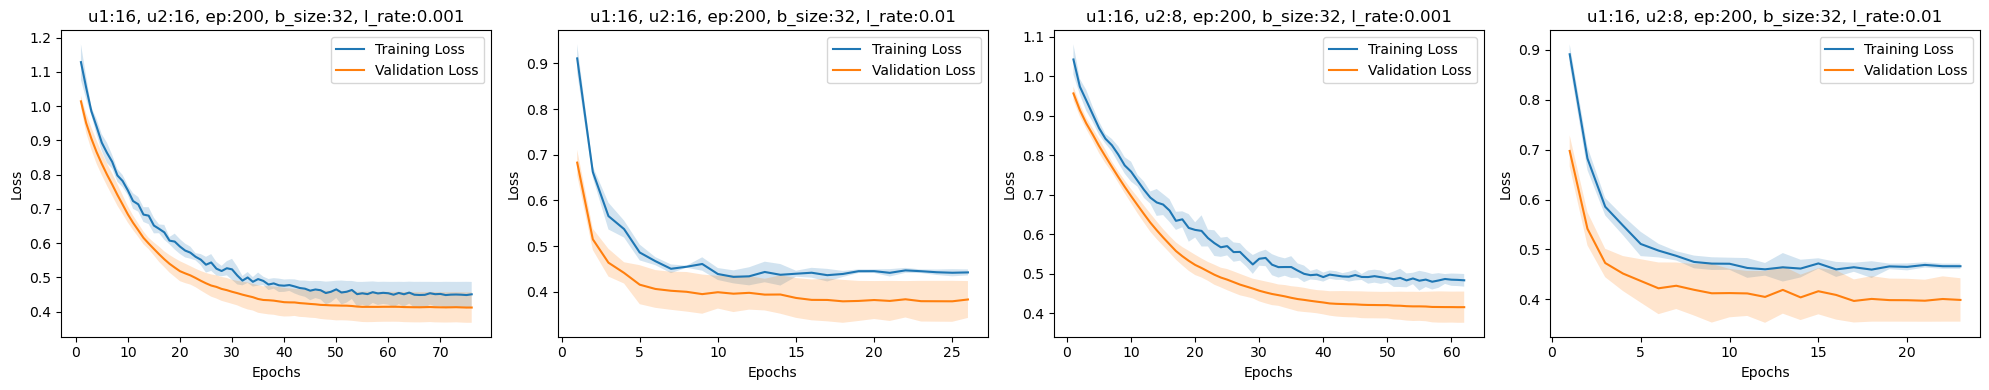

In [198]:
# Plot training & validation loss values
fig, axes = plt.subplots(int(len(baseline_performance_all)/4), 4, figsize=(20, int(len(baseline_performance_all)/4)*4))

axes = axes.flatten()

for ax, (i, performance) in zip(axes, enumerate(baseline_performance_all)):
    
    n = len(performance['history']['loss']['mean'])
    
    ax.plot(list(range(1, n+1)), performance['history']['loss']['mean'], label='Training Loss', )
    ax.plot(list(range(1, n+1)), performance['history']['val_loss']['mean'], label='Validation Loss', )
    
    ax.fill_between(list(range(1, n+1)), performance['history']['loss']['mean'] - performance['history']['loss']['std'], performance['history']['loss']['mean'] + performance['history']['loss']['std'], alpha=0.2)
    ax.fill_between(list(range(1, n+1)), performance['history']['val_loss']['mean'] - performance['history']['val_loss']['std'], performance['history']['val_loss']['mean'] + performance['history']['val_loss']['std'], alpha=0.2)
    
    ax.set_title(f"u1:{performance['params']['u1']}, u2:{performance['params']['u2']}, ep:{performance['params']['epochs']}, b_size:{performance['params']['batch_size']}, l_rate:{performance['params']['learning_rate']}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

In [199]:
baseline_pt_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'][-1],
        'val_loss': p['history']['val_loss']['mean'][-1],
        'auc': p['history']['auc']['mean'][-1],
        'val_auc': p['history']['val_auc']['mean'][-1],
    }, 
    baseline_performance_all
)))

baseline_pt_results_df.loc[
    list(set(baseline_pt_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(baseline_pt_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.450438,0.411793,0.915205,0.934135
1,16,16,200,32,0.010000,0.442250,0.382966,0.908313,0.935101
2,16,8,200,32,0.001000,0.483178,0.415089,0.897993,0.932661
3,16,8,200,32,0.010000,0.466513,0.399004,0.898383,0.935725


In [200]:
baseline_pt_best_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'].min(),
        'val_loss': p['history']['val_loss']['mean'].min(),
        'auc': p['history']['auc']['mean'].max(),
        'val_auc': p['history']['val_auc']['mean'].max(),
    }, 
    baseline_performance_all
)))

baseline_pt_best_results_df.loc[
    list(set(baseline_pt_best_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(baseline_pt_best_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.448218,0.411771,0.916397,0.934444
1,16,16,200,32,0.010000,0.432484,0.378931,0.916569,0.935850
2,16,8,200,32,0.001000,0.479535,0.415051,0.899826,0.933004
3,16,8,200,32,0.010000,0.459735,0.396968,0.905222,0.935725


In [201]:
baseline_learning_all = []

training_sizes = np.linspace(0.1, 0.9, 9)

# Perform grid search
for size in training_sizes:
    print(f"Size: {size:.1f}")
    
    train_losses = []
    val_losses = []

    train_aucs = []
    val_aucs = []

    subset_size = int(len(X_train) * size)
    _X_train_subset = X_train[:subset_size]
    _y_train_subset = y_train[:subset_size]
    
    _X_train_subset = pd.DataFrame(_X_train_subset)
    _y_train_subset = pd.DataFrame(_y_train_subset)
    
    for train_index, val_index in kf.split(_X_train_subset, _y_train_subset):
        _X_train, X_val = _X_train_subset.iloc[train_index], _X_train_subset.iloc[val_index]
        _y_train, y_val = _y_train_subset.iloc[train_index], _y_train_subset.iloc[val_index]

        # Create a model instance
        model = create_model(_X_train.shape[1], 16, 16, 0.01)

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(_X_train, _y_train, 
                            epochs=200, 
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_predictions = model.predict(X_val, verbose=0)

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        train_aucs.append(history.history['AUC'])
        val_aucs.append(history.history['val_AUC'])

    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
    
    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
    
    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
    
    baseline_learning_current = {
        'training_size': subset_size,
        
        'history':
            {
              'loss': {
                  'mean': np.mean(train_losses, axis=0),
                  'std': np.std(train_losses, axis=0)
              },
              'val_loss': {
                  'mean': np.mean(val_losses, axis=0),
                  'std': np.std(val_losses, axis=0)
              },
              'auc': {
                  'mean': np.mean(train_aucs, axis=0),
                  'std': np.std(train_aucs, axis=0)
              },
              'val_auc': {
                  'mean': np.mean(val_aucs, axis=0),
                  'std': np.std(val_aucs, axis=0)
              },
            }
        }

    baseline_learning_all.append(baseline_learning_current)

Size: 0.1
Size: 0.2
Size: 0.3
Size: 0.4
Size: 0.5
Size: 0.6
Size: 0.7
Size: 0.8
Size: 0.9


In [202]:
# plt.figure(figsize=(8, 5))

# # n = len(baseline_learning_all['history']['loss']['mean'])

# plt.plot(list(range(1, 101)), baseline_learning_all[-1]['history']['loss']['mean'], label='Training Loss', )
# plt.plot(list(range(1, 101)), baseline_learning_all[-1]['history']['val_loss']['mean'], label='Validation Loss', )

# plt.fill_between(list(range(1, 101)), baseline_learning_all[-1]['history']['loss']['mean'] - baseline_learning_all[-1]['history']['loss']['std'], baseline_learning_all[-1]['history']['loss']['mean'] + baseline_learning_all[-1]['history']['loss']['std'], alpha=0.2)
# plt.fill_between(list(range(1, 101)), baseline_learning_all[-1]['history']['val_loss']['mean'] - baseline_learning_all[-1]['history']['val_loss']['std'], baseline_learning_all[-1]['history']['val_loss']['mean'] + baseline_learning_all[-1]['history']['val_loss']['std'], alpha=0.2)

# plt.title("Learning Curve - Training Sizes")
# plt.xlabel('Training Size')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

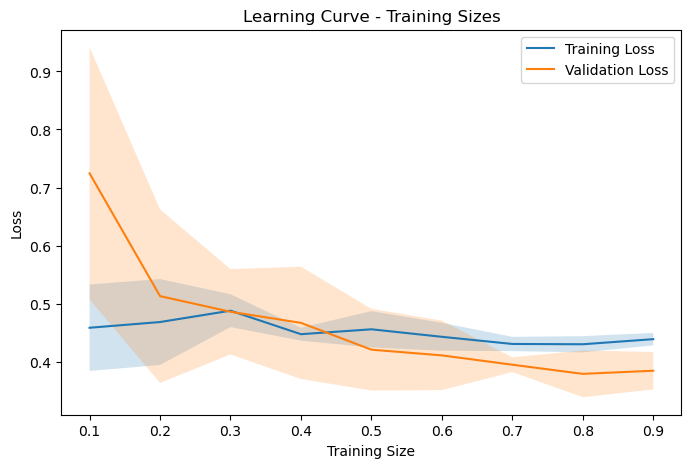

In [203]:
plt.figure(figsize=(8, 5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in baseline_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in baseline_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in baseline_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in baseline_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in baseline_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in baseline_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [161]:
# hyperparameter ranges
units1 = [16]
units2 = [16, 8]
epoch_list = [200]
batch_size_list = [32]
learning_rate_list = [0.001, 0.01]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pca_performance_all = []

n_X_train_pca = pd.DataFrame(X_train_pca)

# search
for u1 in units1:
    for u2 in units2:
        for epochs in epoch_list:
            for batch_size in batch_size_list:
                for learning_rate in learning_rate_list:
                    
                    print(f"u1:{u1}, u2:{u2}, epochs:{epochs}, batch_size:{batch_size}, learning_rate:{learning_rate}")
                    
                    train_losses = []
                    val_losses = []
                    
                    train_aucs = []
                    val_aucs = []
                    
                    for train_index, val_index in kf.split(n_X_train_pca, y_train):
                        _X_train_pca, X_val_pca = n_X_train_pca.iloc[train_index], n_X_train_pca.iloc[val_index]
                        _y_train, y_val = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[val_index]

                        # Create a model instance
                        model = create_model(n_X_train_pca.shape[1], u1, u2, learning_rate)

                        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                        # Train the model
                        history = model.fit(_X_train_pca, _y_train, 
                                            epochs=epochs, 
                                            batch_size=batch_size,
                                            validation_data=(X_val_pca, y_val),
                                            callbacks=[early_stopping],
                                            verbose=0)

                        # Evaluate the model
                        val_predictions = model.predict(X_val_pca, verbose=0)
                
                        train_losses.append(history.history['loss'])
                        val_losses.append(history.history['val_loss'])
                
                        train_aucs.append(history.history['AUC'])
                        val_aucs.append(history.history['val_AUC'])
                        
                    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
                    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
                    
                    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
                    
                    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
                        
                        # train_losses.append(history.history['loss'])
                        # val_losses.append(history.history['val_loss'])

                        # train_accuracies.append(history.history['accuracy'])
                        # val_accuracies.append(history.history['val_accuracy'])
                        
                    pca_performace_current = {'params':
                                          {
                                              'u1': u1,
                                              'u2': u2,
                                              'epochs': epochs,
                                              'batch_size': batch_size,
                                              'learning_rate': learning_rate,
                                          },
                                          
                                          'history':
                                          {
                                              'loss': {
                                                  'mean': np.mean(train_losses, axis=0),
                                                  'std': np.std(train_losses, axis=0)
                                              },
                                              'val_loss': {
                                                  'mean': np.mean(val_losses, axis=0),
                                                  'std': np.std(val_losses, axis=0)
                                              },
                                              'auc': {
                                                  'mean': np.mean(train_aucs, axis=0),
                                                  'std': np.std(train_aucs, axis=0)
                                              },
                                              'val_auc': {
                                                  'mean': np.mean(val_aucs, axis=0),
                                                  'std': np.std(val_aucs, axis=0)
                                              },
                                          }
                                         }
                        
                    pca_performance_all.append(pca_performace_current)

u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.01
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.01


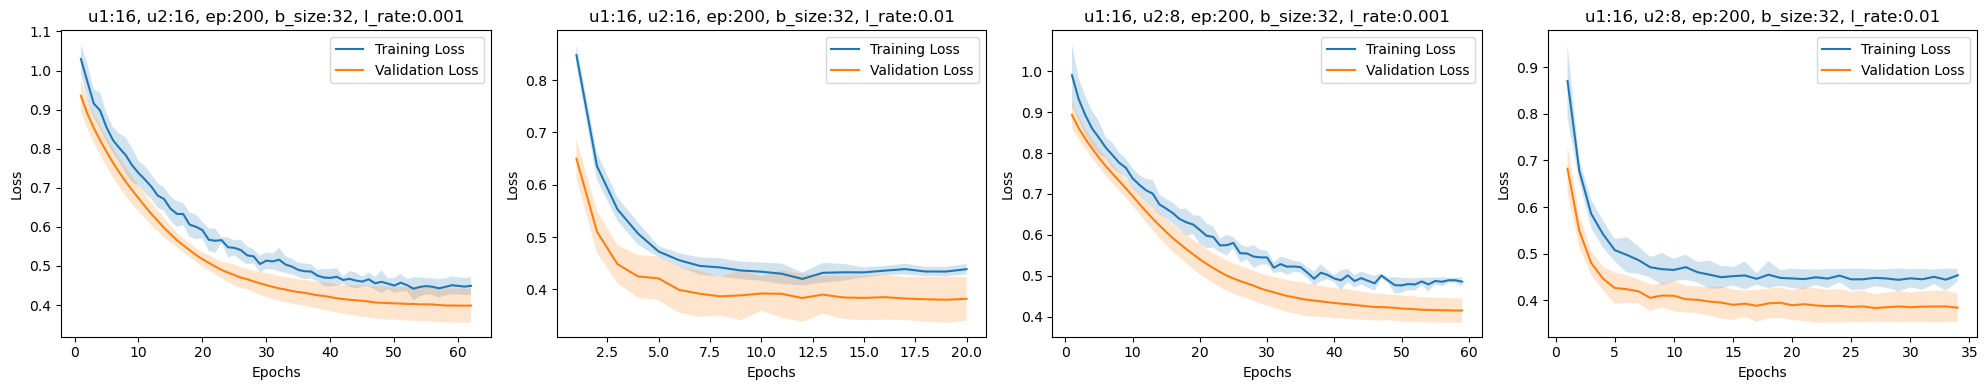

In [162]:
# Plot training & validation loss values
fig, axes = plt.subplots(int(len(pca_performance_all)/4), 4, figsize=(20, int(len(pca_performance_all)/4)*4))

axes = axes.flatten()

for ax, (i, performance) in zip(axes, enumerate(pca_performance_all)):
    
    n = len(performance['history']['loss']['mean'])
    
    ax.plot(list(range(1, n+1)), performance['history']['loss']['mean'], label='Training Loss', )
    ax.plot(list(range(1, n+1)), performance['history']['val_loss']['mean'], label='Validation Loss', )
    
    ax.fill_between(list(range(1, n+1)), performance['history']['loss']['mean'] - performance['history']['loss']['std'], performance['history']['loss']['mean'] + performance['history']['loss']['std'], alpha=0.2)
    ax.fill_between(list(range(1, n+1)), performance['history']['val_loss']['mean'] - performance['history']['val_loss']['std'], performance['history']['val_loss']['mean'] + performance['history']['val_loss']['std'], alpha=0.2)
    
    ax.set_title(f"u1:{performance['params']['u1']}, u2:{performance['params']['u2']}, ep:{performance['params']['epochs']}, b_size:{performance['params']['batch_size']}, l_rate:{performance['params']['learning_rate']}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

In [163]:
pca_pt_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'][-1],
        'val_loss': p['history']['val_loss']['mean'][-1],
        'auc': p['history']['auc']['mean'][-1],
        'val_auc': p['history']['val_auc']['mean'][-1],
    }, 
    pca_performance_all
)))

pca_pt_results_df.loc[
    list(set(pca_pt_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(pca_pt_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.449113,0.398737,0.911761,0.932041
1,16,16,200,32,0.010000,0.438465,0.381808,0.910175,0.934067
2,16,8,200,32,0.001000,0.485854,0.415290,0.892287,0.931226
3,16,8,200,32,0.010000,0.453957,0.384543,0.898818,0.933199


In [164]:
pca_pt_best_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'].min(),
        'val_loss': p['history']['val_loss']['mean'].min(),
        'auc': p['history']['auc']['mean'].max(),
        'val_auc': p['history']['val_auc']['mean'].max(),
    }, 
    pca_performance_all
)))

pca_pt_best_results_df.loc[
    list(set(pca_pt_best_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(pca_pt_best_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.441759,0.398448,0.916109,0.932195
1,16,16,200,32,0.010000,0.419761,0.380016,0.917754,0.935035
2,16,8,200,32,0.001000,0.476848,0.415290,0.901375,0.931303
3,16,8,200,32,0.010000,0.444161,0.383799,0.904562,0.934042


In [165]:
pca_learning_all = []

training_sizes = np.linspace(0.1, 0.9, 9)

# Perform grid search
for size in training_sizes:
    print(f"Size: {size:.1f}")
    
    train_losses = []
    val_losses = []

    train_aucs = []
    val_aucs = []

    subset_size = int(len(X_train_pca) * size)
    _X_train_pca_subset = X_train_pca[:subset_size]
    _y_train_subset = y_train[:subset_size]
    
    _X_train_pca_subset = pd.DataFrame(_X_train_pca_subset)
    _y_train_subset = pd.DataFrame(_y_train_subset)
    
    for train_index, val_index in kf.split(_X_train_pca_subset, _y_train_subset):
        _X_train_pca, X_val_pca = _X_train_pca_subset.iloc[train_index], _X_train_pca_subset.iloc[val_index]
        _y_train, y_val = _y_train_subset.iloc[train_index], _y_train_subset.iloc[val_index]

        # Create a model instance
        model = create_model(_X_train_pca.shape[1], 16, 16, 0.01)

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(_X_train_pca, _y_train, 
                            epochs=200, 
                            batch_size=32,
                            validation_data=(X_val_pca, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_predictions = model.predict(X_val_pca, verbose=0)

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        train_aucs.append(history.history['AUC'])
        val_aucs.append(history.history['val_AUC'])

    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
    
    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
    
    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
    
    pca_learning_current = {
        'training_size': subset_size,
        
        'history':
            {
              'loss': {
                  'mean': np.mean(train_losses, axis=0),
                  'std': np.std(train_losses, axis=0)
              },
              'val_loss': {
                  'mean': np.mean(val_losses, axis=0),
                  'std': np.std(val_losses, axis=0)
              },
              'auc': {
                  'mean': np.mean(train_aucs, axis=0),
                  'std': np.std(train_aucs, axis=0)
              },
              'val_auc': {
                  'mean': np.mean(val_aucs, axis=0),
                  'std': np.std(val_aucs, axis=0)
              },
            }
        }

    pca_learning_all.append(pca_learning_current)

Size: 0.1
Size: 0.2
Size: 0.3
Size: 0.4
Size: 0.5
Size: 0.6
Size: 0.7
Size: 0.8
Size: 0.9


In [167]:
# plt.figure(figsize=(8, 5))

# # n = len(pca_learning_all['history']['loss']['mean'])

# plt.plot(list(range(1, 101)), pca_learning_all[-1]['history']['loss']['mean'], label='Training Loss', )
# plt.plot(list(range(1, 101)), pca_learning_all[-1]['history']['val_loss']['mean'], label='Validation Loss', )

# plt.fill_between(list(range(1, 101)), pca_learning_all[-1]['history']['loss']['mean'] - pca_learning_all[-1]['history']['loss']['std'], pca_learning_all[-1]['history']['loss']['mean'] + pca_learning_all[-1]['history']['loss']['std'], alpha=0.2)
# plt.fill_between(list(range(1, 101)), pca_learning_all[-1]['history']['val_loss']['mean'] - pca_learning_all[-1]['history']['val_loss']['std'], pca_learning_all[-1]['history']['val_loss']['mean'] + pca_learning_all[-1]['history']['val_loss']['std'], alpha=0.2)

# plt.title("Learning Curve - Training Sizes")
# plt.xlabel('Training Size')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

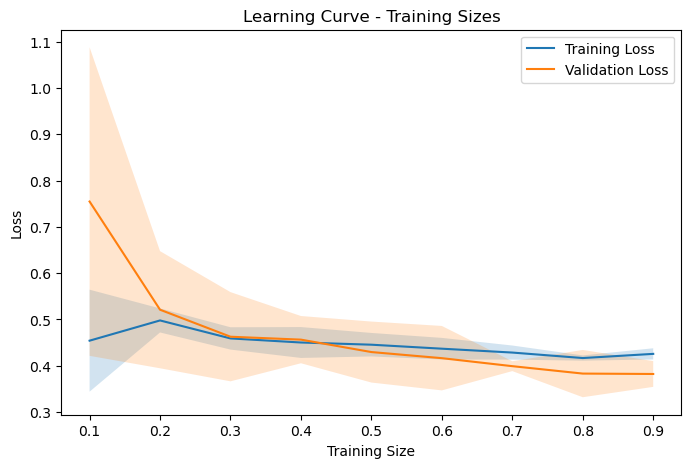

In [166]:
plt.figure(figsize=(8, 5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in pca_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in pca_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in pca_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in pca_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in pca_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in pca_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

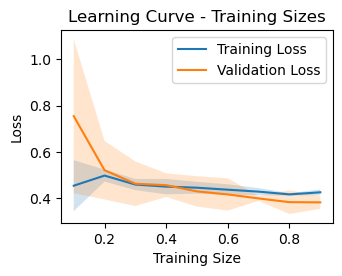

In [343]:
plt.figure(figsize=(3.5, 2.5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in pca_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in pca_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in pca_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in pca_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in pca_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in pca_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [168]:
# hyperparameter ranges
units1 = [16]
units2 = [16, 8]
epoch_list = [200]
batch_size_list = [32]
learning_rate_list = [0.001, 0.01]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ica_performance_all = []

n_X_train_ica = pd.DataFrame(X_train_ica)

# search
for u1 in units1:
    for u2 in units2:
        for epochs in epoch_list:
            for batch_size in batch_size_list:
                for learning_rate in learning_rate_list:
                    
                    print(f"u1:{u1}, u2:{u2}, epochs:{epochs}, batch_size:{batch_size}, learning_rate:{learning_rate}")
                    
                    train_losses = []
                    val_losses = []
                    
                    train_aucs = []
                    val_aucs = []
                    
                    for train_index, val_index in kf.split(n_X_train_ica, y_train):
                        _X_train_ica, X_val_ica = n_X_train_ica.iloc[train_index], n_X_train_ica.iloc[val_index]
                        _y_train, y_val = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[val_index]

                        # Create a model instance
                        model = create_model(n_X_train_ica.shape[1], u1, u2, learning_rate)

                        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                        # Train the model
                        history = model.fit(_X_train_ica, _y_train, 
                                            epochs=epochs, 
                                            batch_size=batch_size,
                                            validation_data=(X_val_ica, y_val),
                                            callbacks=[early_stopping],
                                            verbose=0)

                        # Evaluate the model
                        val_predictions = model.predict(X_val_ica, verbose=0)
                
                        train_losses.append(history.history['loss'])
                        val_losses.append(history.history['val_loss'])
                
                        train_aucs.append(history.history['AUC'])
                        val_aucs.append(history.history['val_AUC'])
                        
                    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
                    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
                    
                    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
                    
                    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]

                    
                    ica_performace_current = {'params':
                                          {
                                              'u1': u1,
                                              'u2': u2,
                                              'epochs': epochs,
                                              'batch_size': batch_size,
                                              'learning_rate': learning_rate,
                                          },
                                          
                                          'history':
                                          {
                                              'loss': {
                                                  'mean': np.mean(train_losses, axis=0),
                                                  'std': np.std(train_losses, axis=0)
                                              },
                                              'val_loss': {
                                                  'mean': np.mean(val_losses, axis=0),
                                                  'std': np.std(val_losses, axis=0)
                                              },
                                              'auc': {
                                                  'mean': np.mean(train_aucs, axis=0),
                                                  'std': np.std(train_aucs, axis=0)
                                              },
                                              'val_auc': {
                                                  'mean': np.mean(val_aucs, axis=0),
                                                  'std': np.std(val_aucs, axis=0)
                                              },
                                          }
                                         }
                        
                    ica_performance_all.append(ica_performace_current)

u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.01
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.01


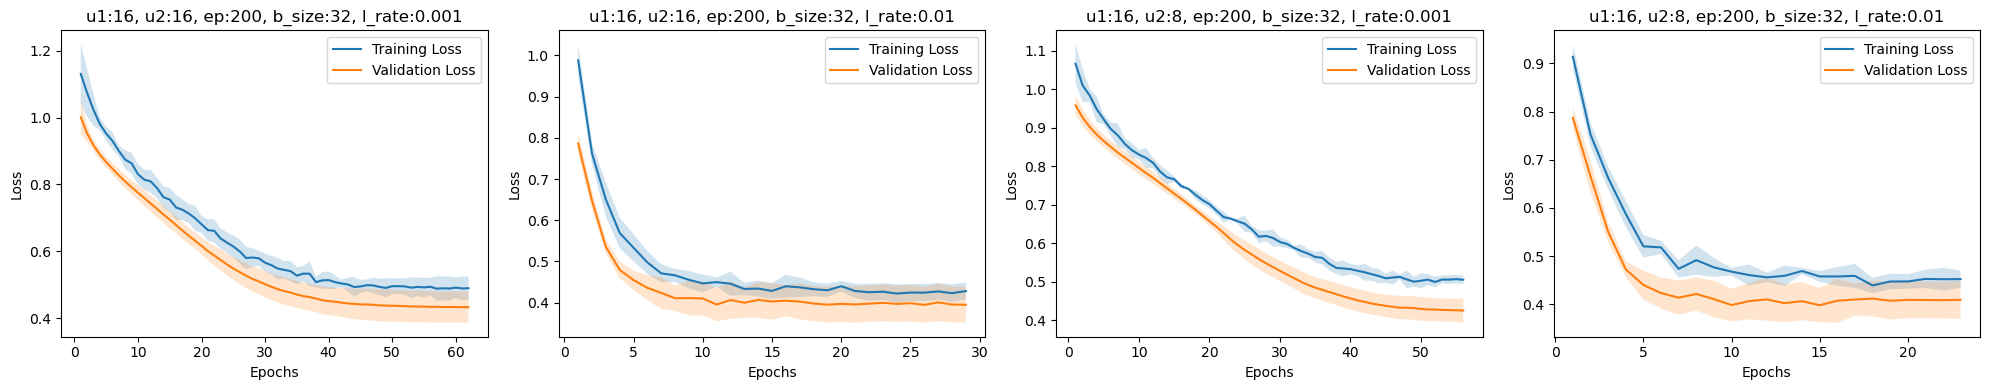

In [169]:
# Plot training & validation loss values
fig, axes = plt.subplots(int(len(ica_performance_all)/4), 4, figsize=(20, int(len(ica_performance_all)/4)*4))

axes = axes.flatten()

for ax, (i, performance) in zip(axes, enumerate(ica_performance_all)):
    
    n = len(performance['history']['loss']['mean'])
    
    ax.plot(list(range(1, n+1)), performance['history']['loss']['mean'], label='Training Loss', )
    ax.plot(list(range(1, n+1)), performance['history']['val_loss']['mean'], label='Validation Loss', )
    
    ax.fill_between(list(range(1, n+1)), performance['history']['loss']['mean'] - performance['history']['loss']['std'], performance['history']['loss']['mean'] + performance['history']['loss']['std'], alpha=0.2)
    ax.fill_between(list(range(1, n+1)), performance['history']['val_loss']['mean'] - performance['history']['val_loss']['std'], performance['history']['val_loss']['mean'] + performance['history']['val_loss']['std'], alpha=0.2)
    
    ax.set_title(f"u1:{performance['params']['u1']}, u2:{performance['params']['u2']}, ep:{performance['params']['epochs']}, b_size:{performance['params']['batch_size']}, l_rate:{performance['params']['learning_rate']}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

In [170]:
ica_pt_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'][-1],
        'val_loss': p['history']['val_loss']['mean'][-1],
        'auc': p['history']['auc']['mean'][-1],
        'val_auc': p['history']['val_auc']['mean'][-1],
    }, 
    ica_performance_all
)))

ica_pt_results_df.loc[
    list(set(ica_pt_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(ica_pt_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.489342,0.432854,0.904816,0.930822
1,16,16,200,32,0.010000,0.428252,0.394940,0.916111,0.932488
2,16,8,200,32,0.001000,0.505147,0.425087,0.889711,0.931603
3,16,8,200,32,0.010000,0.452432,0.409461,0.906692,0.925278


In [171]:
ica_pt_best_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'].min(),
        'val_loss': p['history']['val_loss']['mean'].min(),
        'auc': p['history']['auc']['mean'].max(),
        'val_auc': p['history']['val_auc']['mean'].max(),
    }, 
    ica_performance_all
)))

ica_pt_best_results_df.loc[
    list(set(ica_pt_best_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(ica_pt_best_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.488030,0.432754,0.908776,0.931009
1,16,16,200,32,0.010000,0.422215,0.394731,0.919701,0.934100
2,16,8,200,32,0.001000,0.499305,0.425087,0.892834,0.931603
3,16,8,200,32,0.010000,0.439285,0.398220,0.912448,0.934170


In [172]:
ica_learning_all = []

training_sizes = np.linspace(0.1, 0.9, 9)

# Perform grid search
for size in training_sizes:
    print(f"Size: {size:.1f}")
    
    train_losses = []
    val_losses = []

    train_aucs = []
    val_aucs = []

    subset_size = int(len(X_train_ica) * size)
    _X_train_ica_subset = X_train_ica[:subset_size]
    _y_train_subset = y_train[:subset_size]
    
    _X_train_ica_subset = pd.DataFrame(_X_train_ica_subset)
    _y_train_subset = pd.DataFrame(_y_train_subset)
    
    for train_index, val_index in kf.split(_X_train_ica_subset, _y_train_subset):
        _X_train_ica, X_val_ica = _X_train_ica_subset.iloc[train_index], _X_train_ica_subset.iloc[val_index]
        _y_train, y_val = _y_train_subset.iloc[train_index], _y_train_subset.iloc[val_index]

        # Create a model instance
        model = create_model(_X_train_ica.shape[1], 16, 16, 0.01)

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(_X_train_ica, _y_train, 
                            epochs=200, 
                            batch_size=32,
                            validation_data=(X_val_ica, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_predictions = model.predict(X_val_ica, verbose=0)

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        train_aucs.append(history.history['AUC'])
        val_aucs.append(history.history['val_AUC'])

    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
    
    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
    
    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
    
    ica_learning_current = {
        'training_size': subset_size,
        
        'history':
            {
              'loss': {
                  'mean': np.mean(train_losses, axis=0),
                  'std': np.std(train_losses, axis=0)
              },
              'val_loss': {
                  'mean': np.mean(val_losses, axis=0),
                  'std': np.std(val_losses, axis=0)
              },
              'auc': {
                  'mean': np.mean(train_aucs, axis=0),
                  'std': np.std(train_aucs, axis=0)
              },
              'val_auc': {
                  'mean': np.mean(val_aucs, axis=0),
                  'std': np.std(val_aucs, axis=0)
              },
            }
        }

    ica_learning_all.append(ica_learning_current)

Size: 0.1
Size: 0.2
Size: 0.3
Size: 0.4
Size: 0.5
Size: 0.6
Size: 0.7
Size: 0.8
Size: 0.9


In [173]:
# plt.figure(figsize=(8, 5))

# # n = len(ica_learning_all['history']['loss']['mean'])

# plt.plot(list(range(1, 101)), ica_learning_all[-1]['history']['loss']['mean'], label='Training Loss', )
# plt.plot(list(range(1, 101)), ica_learning_all[-1]['history']['val_loss']['mean'], label='Validation Loss', )

# plt.fill_between(list(range(1, 101)), ica_learning_all[-1]['history']['loss']['mean'] - ica_learning_all[-1]['history']['loss']['std'], ica_learning_all[-1]['history']['loss']['mean'] + ica_learning_all[-1]['history']['loss']['std'], alpha=0.2)
# plt.fill_between(list(range(1, 101)), ica_learning_all[-1]['history']['val_loss']['mean'] - ica_learning_all[-1]['history']['val_loss']['std'], ica_learning_all[-1]['history']['val_loss']['mean'] + ica_learning_all[-1]['history']['val_loss']['std'], alpha=0.2)

# plt.title("Learning Curve - Training Sizes")
# plt.xlabel('Training Size')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

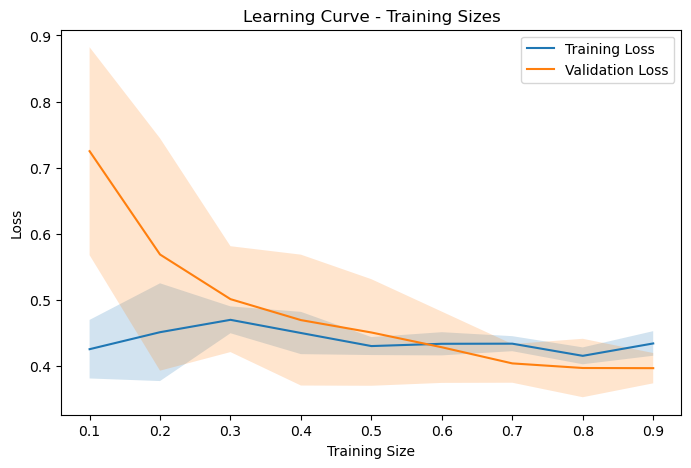

In [174]:
plt.figure(figsize=(8, 5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in ica_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in ica_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in ica_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in ica_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in ica_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in ica_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

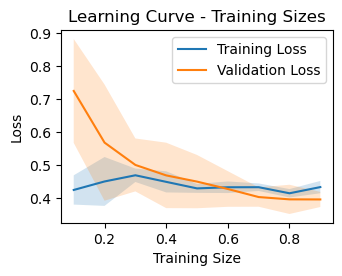

In [344]:
plt.figure(figsize=(3.5, 2.5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in ica_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in ica_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in ica_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in ica_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in ica_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in ica_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [183]:
# hyperparameter ranges
units1 = [16]
units2 = [16, 8]
epoch_list = [200]
batch_size_list = [32]
learning_rate_list = [0.001, 0.01]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rp_performance_all = []

n_X_train_rp = pd.DataFrame(X_train_rp)

# search
for u1 in units1:
    for u2 in units2:
        for epochs in epoch_list:
            for batch_size in batch_size_list:
                for learning_rate in learning_rate_list:
                    
                    print(f"u1:{u1}, u2:{u2}, epochs:{epochs}, batch_size:{batch_size}, learning_rate:{learning_rate}")
                    
                    train_losses = []
                    val_losses = []
                    
                    train_aucs = []
                    val_aucs = []
                    
                    for train_index, val_index in kf.split(n_X_train_rp, y_train):
                        _X_train_rp, X_val_rp = n_X_train_rp.iloc[train_index], n_X_train_rp.iloc[val_index]
                        _y_train, y_val = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[val_index]

                        # Create a model instance
                        model = create_model(n_X_train_rp.shape[1], u1, u2, learning_rate)

                        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                        # Train the model
                        history = model.fit(_X_train_rp, _y_train, 
                                            epochs=epochs, 
                                            batch_size=batch_size,
                                            validation_data=(X_val_rp, y_val),
                                            callbacks=[early_stopping],
                                            verbose=0)

                        # Evaluate the model
                        val_predictions = model.predict(X_val_rp, verbose=0)
                
                        train_losses.append(history.history['loss'])
                        val_losses.append(history.history['val_loss'])
                
                        train_aucs.append(history.history['AUC'])
                        val_aucs.append(history.history['val_AUC'])
                        
                    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
                    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
                    
                    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
                    
                    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]

                    
                    rp_performace_current = {'params':
                                          {
                                              'u1': u1,
                                              'u2': u2,
                                              'epochs': epochs,
                                              'batch_size': batch_size,
                                              'learning_rate': learning_rate,
                                          },
                                          
                                          'history':
                                          {
                                              'loss': {
                                                  'mean': np.mean(train_losses, axis=0),
                                                  'std': np.std(train_losses, axis=0)
                                              },
                                              'val_loss': {
                                                  'mean': np.mean(val_losses, axis=0),
                                                  'std': np.std(val_losses, axis=0)
                                              },
                                              'auc': {
                                                  'mean': np.mean(train_aucs, axis=0),
                                                  'std': np.std(train_aucs, axis=0)
                                              },
                                              'val_auc': {
                                                  'mean': np.mean(val_aucs, axis=0),
                                                  'std': np.std(val_aucs, axis=0)
                                              },
                                          }
                                         }
                        
                    rp_performance_all.append(rp_performace_current)

u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.01
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.01


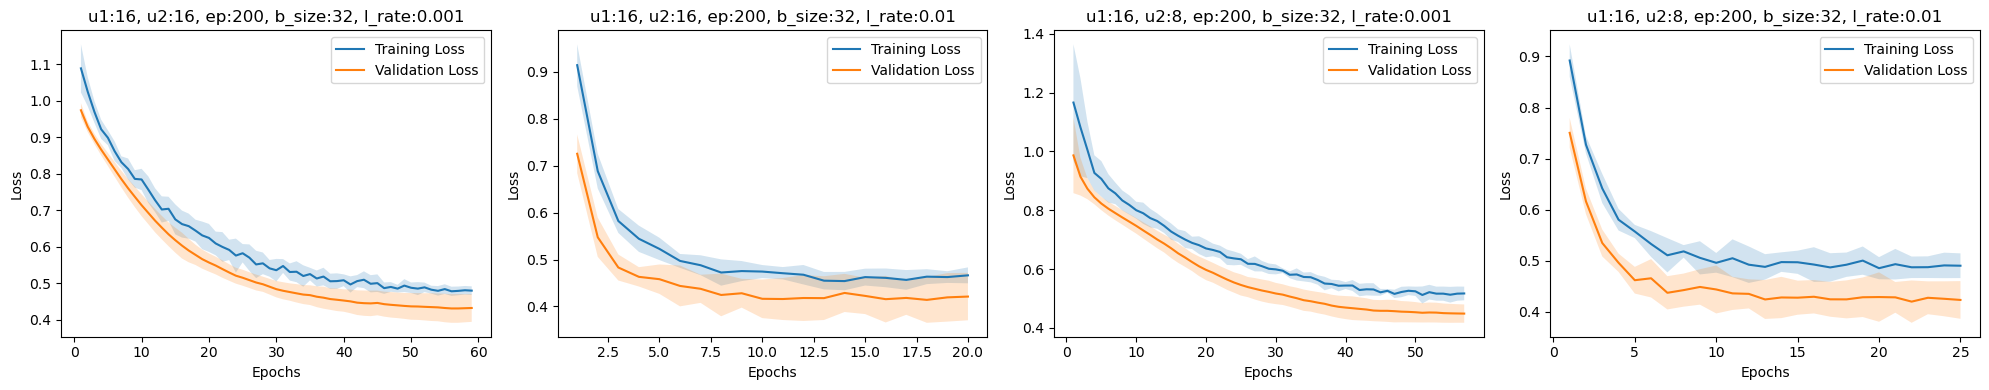

In [184]:
# Plot training & validation loss values
fig, axes = plt.subplots(int(len(rp_performance_all)/4), 4, figsize=(20, int(len(rp_performance_all)/4)*4))

axes = axes.flatten()

for ax, (i, performance) in zip(axes, enumerate(rp_performance_all)):
    
    n = len(performance['history']['loss']['mean'])
    
    ax.plot(list(range(1, n+1)), performance['history']['loss']['mean'], label='Training Loss', )
    ax.plot(list(range(1, n+1)), performance['history']['val_loss']['mean'], label='Validation Loss', )
    
    ax.fill_between(list(range(1, n+1)), performance['history']['loss']['mean'] - performance['history']['loss']['std'], performance['history']['loss']['mean'] + performance['history']['loss']['std'], alpha=0.2)
    ax.fill_between(list(range(1, n+1)), performance['history']['val_loss']['mean'] - performance['history']['val_loss']['std'], performance['history']['val_loss']['mean'] + performance['history']['val_loss']['std'], alpha=0.2)
    
    ax.set_title(f"u1:{performance['params']['u1']}, u2:{performance['params']['u2']}, ep:{performance['params']['epochs']}, b_size:{performance['params']['batch_size']}, l_rate:{performance['params']['learning_rate']}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

In [185]:
rp_pt_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'][-1],
        'val_loss': p['history']['val_loss']['mean'][-1],
        'auc': p['history']['auc']['mean'][-1],
        'val_auc': p['history']['val_auc']['mean'][-1],
    }, 
    rp_performance_all
)))

rp_pt_results_df.loc[
    list(set(rp_pt_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(rp_pt_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.479276,0.431637,0.899592,0.927419
1,16,16,200,32,0.010000,0.466208,0.420943,0.896147,0.927897
2,16,8,200,32,0.001000,0.516885,0.448368,0.882682,0.928901
3,16,8,200,32,0.010000,0.490367,0.423384,0.881717,0.930839


In [186]:
rp_pt_best_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'].min(),
        'val_loss': p['history']['val_loss']['mean'].min(),
        'auc': p['history']['auc']['mean'].max(),
        'val_auc': p['history']['val_auc']['mean'].max(),
    }, 
    rp_performance_all
)))

rp_pt_best_results_df.loc[
    list(set(rp_pt_best_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(rp_pt_best_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.477481,0.430379,0.900453,0.927669
1,16,16,200,32,0.010000,0.453959,0.413836,0.903638,0.929583
2,16,8,200,32,0.001000,0.511719,0.448368,0.887132,0.929010
3,16,8,200,32,0.010000,0.485519,0.420080,0.885035,0.931054


In [187]:
rp_learning_all = []

training_sizes = np.linspace(0.1, 0.9, 9)

# Perform grid search
for size in training_sizes:
    print(f"Size: {size:.1f}")
    
    train_losses = []
    val_losses = []

    train_aucs = []
    val_aucs = []

    subset_size = int(len(X_train_rp) * size)
    _X_train_rp_subset = X_train_rp[:subset_size]
    _y_train_subset = y_train[:subset_size]
    
    _X_train_rp_subset = pd.DataFrame(_X_train_rp_subset)
    _y_train_subset = pd.DataFrame(_y_train_subset)
    
    for train_index, val_index in kf.split(_X_train_rp_subset, _y_train_subset):
        _X_train_rp, X_val_rp = _X_train_rp_subset.iloc[train_index], _X_train_rp_subset.iloc[val_index]
        _y_train, y_val = _y_train_subset.iloc[train_index], _y_train_subset.iloc[val_index]

        # Create a model instance
        model = create_model(_X_train_rp.shape[1], 16, 16, 0.01)

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(_X_train_rp, _y_train, 
                            epochs=200, 
                            batch_size=32,
                            validation_data=(X_val_rp, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_predictions = model.predict(X_val_rp, verbose=0)

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        train_aucs.append(history.history['AUC'])
        val_aucs.append(history.history['val_AUC'])

    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
    
    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
    
    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
    
    rp_learning_current = {
        'training_size': subset_size,
        
        'history':
            {
              'loss': {
                  'mean': np.mean(train_losses, axis=0),
                  'std': np.std(train_losses, axis=0)
              },
              'val_loss': {
                  'mean': np.mean(val_losses, axis=0),
                  'std': np.std(val_losses, axis=0)
              },
              'auc': {
                  'mean': np.mean(train_aucs, axis=0),
                  'std': np.std(train_aucs, axis=0)
              },
              'val_auc': {
                  'mean': np.mean(val_aucs, axis=0),
                  'std': np.std(val_aucs, axis=0)
              },
            }
        }

    rp_learning_all.append(rp_learning_current)

Size: 0.1
Size: 0.2
Size: 0.3
Size: 0.4
Size: 0.5
Size: 0.6
Size: 0.7
Size: 0.8
Size: 0.9


In [188]:
# plt.figure(figsize=(8, 5))

# # n = len(rp_learning_all['history']['loss']['mean'])

# plt.plot(list(range(1, 101)), rp_learning_all[-1]['history']['loss']['mean'], label='Training Loss', )
# plt.plot(list(range(1, 101)), rp_learning_all[-1]['history']['val_loss']['mean'], label='Validation Loss', )

# plt.fill_between(list(range(1, 101)), rp_learning_all[-1]['history']['loss']['mean'] - rp_learning_all[-1]['history']['loss']['std'], rp_learning_all[-1]['history']['loss']['mean'] + rp_learning_all[-1]['history']['loss']['std'], alpha=0.2)
# plt.fill_between(list(range(1, 101)), rp_learning_all[-1]['history']['val_loss']['mean'] - rp_learning_all[-1]['history']['val_loss']['std'], rp_learning_all[-1]['history']['val_loss']['mean'] + rp_learning_all[-1]['history']['val_loss']['std'], alpha=0.2)

# plt.title("Learning Curve - Training Sizes")
# plt.xlabel('Training Size')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

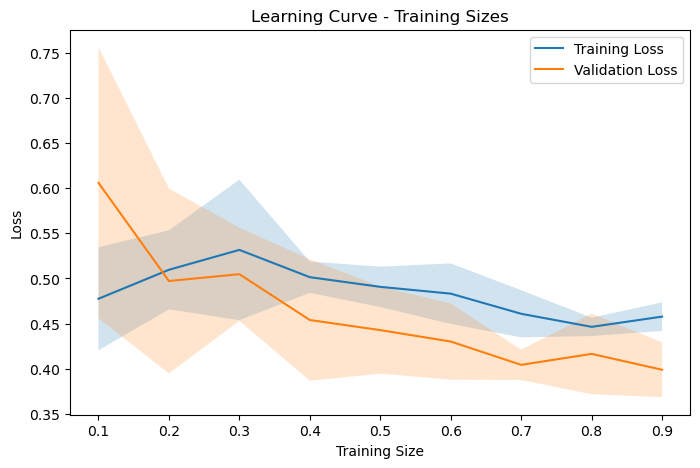

In [189]:
plt.figure(figsize=(8, 5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in rp_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in rp_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in rp_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in rp_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in rp_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in rp_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [190]:
# hypeisomaparameter ranges
units1 = [16]
units2 = [16, 8]
epoch_list = [200]
batch_size_list = [32]
learning_rate_list = [0.001, 0.01]

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

isomap_performance_all = []

n_X_train_isomap = pd.DataFrame(X_train_isomap)

# search
for u1 in units1:
    for u2 in units2:
        for epochs in epoch_list:
            for batch_size in batch_size_list:
                for learning_rate in learning_rate_list:
                    
                    print(f"u1:{u1}, u2:{u2}, epochs:{epochs}, batch_size:{batch_size}, learning_rate:{learning_rate}")
                    
                    train_losses = []
                    val_losses = []
                    
                    train_aucs = []
                    val_aucs = []
                    
                    for train_index, val_index in kf.split(n_X_train_isomap, y_train):
                        _X_train_isomap, X_val_isomap = n_X_train_isomap.iloc[train_index], n_X_train_isomap.iloc[val_index]
                        _y_train, y_val = pd.DataFrame(y_train).iloc[train_index], pd.DataFrame(y_train).iloc[val_index]

                        # Create a model instance
                        model = create_model(n_X_train_isomap.shape[1], u1, u2, learning_rate)

                        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

                        # Train the model
                        history = model.fit(_X_train_isomap, _y_train, 
                                            epochs=epochs, 
                                            batch_size=batch_size,
                                            validation_data=(X_val_isomap, y_val),
                                            callbacks=[early_stopping],
                                            verbose=0)

                        # Evaluate the model
                        val_predictions = model.predict(X_val_isomap, verbose=0)
                
                        train_losses.append(history.history['loss'])
                        val_losses.append(history.history['val_loss'])
                
                        train_aucs.append(history.history['AUC'])
                        val_aucs.append(history.history['val_AUC'])
                        
                    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
                    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
                    
                    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
                    
                    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]

                    
                    isomap_performace_current = {'params':
                                          {
                                              'u1': u1,
                                              'u2': u2,
                                              'epochs': epochs,
                                              'batch_size': batch_size,
                                              'learning_rate': learning_rate,
                                          },
                                          
                                          'history':
                                          {
                                              'loss': {
                                                  'mean': np.mean(train_losses, axis=0),
                                                  'std': np.std(train_losses, axis=0)
                                              },
                                              'val_loss': {
                                                  'mean': np.mean(val_losses, axis=0),
                                                  'std': np.std(val_losses, axis=0)
                                              },
                                              'auc': {
                                                  'mean': np.mean(train_aucs, axis=0),
                                                  'std': np.std(train_aucs, axis=0)
                                              },
                                              'val_auc': {
                                                  'mean': np.mean(val_aucs, axis=0),
                                                  'std': np.std(val_aucs, axis=0)
                                              },
                                          }
                                         }
                        
                    isomap_performance_all.append(isomap_performace_current)

u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:16, epochs:200, batch_size:32, learning_rate:0.01
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.001
u1:16, u2:8, epochs:200, batch_size:32, learning_rate:0.01


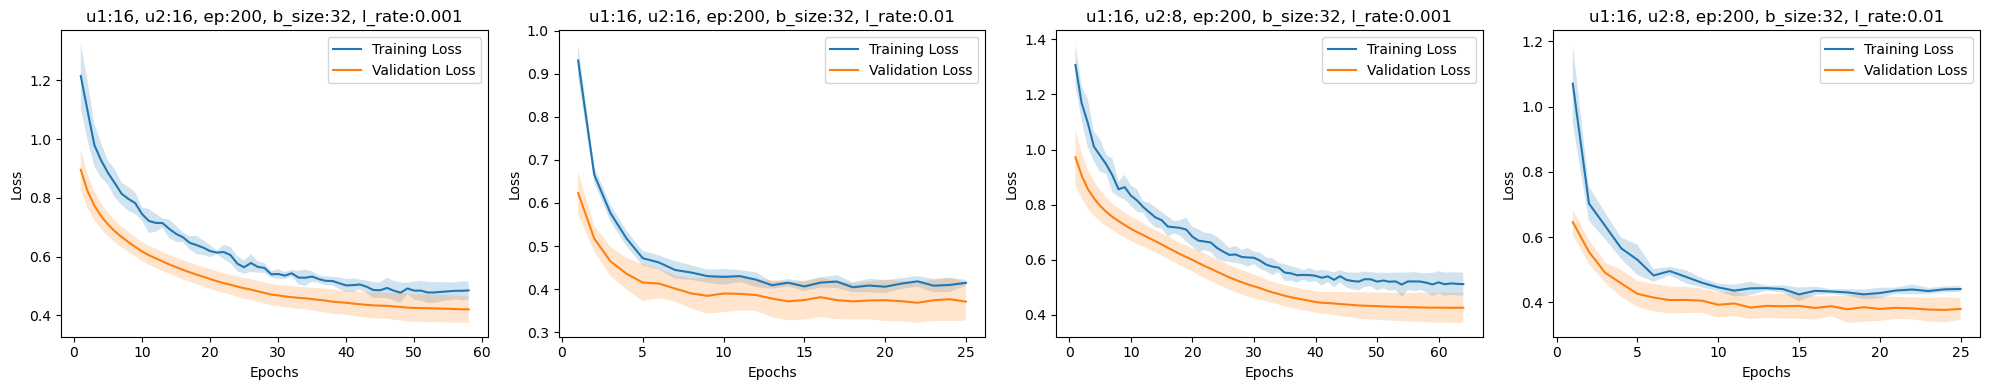

In [191]:
# Plot training & validation loss values
fig, axes = plt.subplots(int(len(isomap_performance_all)/4), 4, figsize=(20, int(len(isomap_performance_all)/4)*4))

axes = axes.flatten()

for ax, (i, performance) in zip(axes, enumerate(isomap_performance_all)):
    
    n = len(performance['history']['loss']['mean'])
    
    ax.plot(list(range(1, n+1)), performance['history']['loss']['mean'], label='Training Loss', )
    ax.plot(list(range(1, n+1)), performance['history']['val_loss']['mean'], label='Validation Loss', )
    
    ax.fill_between(list(range(1, n+1)), performance['history']['loss']['mean'] - performance['history']['loss']['std'], performance['history']['loss']['mean'] + performance['history']['loss']['std'], alpha=0.2)
    ax.fill_between(list(range(1, n+1)), performance['history']['val_loss']['mean'] - performance['history']['val_loss']['std'], performance['history']['val_loss']['mean'] + performance['history']['val_loss']['std'], alpha=0.2)
    
    ax.set_title(f"u1:{performance['params']['u1']}, u2:{performance['params']['u2']}, ep:{performance['params']['epochs']}, b_size:{performance['params']['batch_size']}, l_rate:{performance['params']['learning_rate']}")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.tight_layout()
plt.show()

In [192]:
isomap_pt_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'][-1],
        'val_loss': p['history']['val_loss']['mean'][-1],
        'auc': p['history']['auc']['mean'][-1],
        'val_auc': p['history']['val_auc']['mean'][-1],
    }, 
    isomap_performance_all
)))

isomap_pt_results_df.loc[
    list(set(isomap_pt_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(isomap_pt_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.485285,0.420724,0.910261,0.930721
1,16,16,200,32,0.010000,0.414623,0.370884,0.914489,0.929647
2,16,8,200,32,0.001000,0.511165,0.425405,0.886006,0.928046
3,16,8,200,32,0.010000,0.440921,0.379864,0.900344,0.929472


In [193]:
isomap_pt_best_results_df = pd.DataFrame(list(map(
    lambda p: 
    {
        'u1': p['params']['u1'],
        'u2': p['params']['u2'],
        'epochs': p['params']['epochs'],
        'batch_size': p['params']['batch_size'],
        'learning_rate': p['params']['learning_rate'],
        'loss': p['history']['loss']['mean'].min(),
        'val_loss': p['history']['val_loss']['mean'].min(),
        'auc': p['history']['auc']['mean'].max(),
        'val_auc': p['history']['val_auc']['mean'].max(),
    }, 
    isomap_performance_all
)))

isomap_pt_best_results_df.loc[
    list(set(isomap_pt_best_results_df.sort_values(['val_loss', 'val_auc'], ascending=[True, False]).head(10).index).intersection(
        set(isomap_pt_best_results_df.sort_values(['val_auc', 'val_loss'], ascending=[False, True]).head(10).index)
    ))
].style.highlight_min(axis=0, color='lightgreen', subset=['loss', 'val_loss'])

,u1,u2,epochs,batch_size,learning_rate,loss,val_loss,auc,val_auc
0,16,16,200,32,0.001000,0.477443,0.420724,0.914296,0.930721
1,16,16,200,32,0.010000,0.404256,0.368225,0.920501,0.931276
2,16,8,200,32,0.001000,0.509535,0.425085,0.889263,0.928108
3,16,8,200,32,0.010000,0.424446,0.376796,0.914344,0.932475


In [194]:
isomap_learning_all = []

training_sizes = np.linspace(0.1, 0.9, 9)

# Perform grid search
for size in training_sizes:
    print(f"Size: {size:.1f}")
    
    train_losses = []
    val_losses = []

    train_aucs = []
    val_aucs = []

    subset_size = int(len(X_train_isomap) * size)
    _X_train_isomap_subset = X_train_isomap[:subset_size]
    _y_train_subset = y_train[:subset_size]
    
    _X_train_isomap_subset = pd.DataFrame(_X_train_isomap_subset)
    _y_train_subset = pd.DataFrame(_y_train_subset)
    
    for train_index, val_index in kf.split(_X_train_isomap_subset, _y_train_subset):
        _X_train_isomap, X_val_isomap = _X_train_isomap_subset.iloc[train_index], _X_train_isomap_subset.iloc[val_index]
        _y_train, y_val = _y_train_subset.iloc[train_index], _y_train_subset.iloc[val_index]

        # Create a model instance
        model = create_model(_X_train_isomap.shape[1], 16, 16, 0.01)

        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

        # Train the model
        history = model.fit(_X_train_isomap, _y_train, 
                            epochs=200, 
                            batch_size=32,
                            validation_data=(X_val_isomap, y_val),
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_predictions = model.predict(X_val_isomap, verbose=0)

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])

        train_aucs.append(history.history['AUC'])
        val_aucs.append(history.history['val_AUC'])

    train_losses = [arr + [arr[-1]]*(len(max(train_losses, key=len)) - len(arr)) for arr in train_losses]
                    
    val_losses = [arr + [arr[-1]]*(len(max(val_losses, key=len)) - len(arr)) for arr in val_losses]
    
    train_aucs = [arr + [arr[-1]]*(len(max(train_aucs, key=len)) - len(arr)) for arr in train_aucs]
    
    val_aucs = [arr + [arr[-1]]*(len(max(val_aucs, key=len)) - len(arr)) for arr in val_aucs]
    
    isomap_learning_current = {
        'training_size': subset_size,
        
        'history':
            {
              'loss': {
                  'mean': np.mean(train_losses, axis=0),
                  'std': np.std(train_losses, axis=0)
              },
              'val_loss': {
                  'mean': np.mean(val_losses, axis=0),
                  'std': np.std(val_losses, axis=0)
              },
              'auc': {
                  'mean': np.mean(train_aucs, axis=0),
                  'std': np.std(train_aucs, axis=0)
              },
              'val_auc': {
                  'mean': np.mean(val_aucs, axis=0),
                  'std': np.std(val_aucs, axis=0)
              },
            }
        }

    isomap_learning_all.append(isomap_learning_current)

Size: 0.1
Size: 0.2
Size: 0.3
Size: 0.4
Size: 0.5
Size: 0.6
Size: 0.7
Size: 0.8
Size: 0.9


In [195]:
# plt.figure(figsize=(8, 5))

# # n = len(isomap_learning_all['history']['loss']['mean'])

# plt.plot(list(range(1, 101)), isomap_learning_all[-1]['history']['loss']['mean'], label='Training Loss', )
# plt.plot(list(range(1, 101)), isomap_learning_all[-1]['history']['val_loss']['mean'], label='Validation Loss', )

# plt.fill_between(list(range(1, 101)), isomap_learning_all[-1]['history']['loss']['mean'] - isomap_learning_all[-1]['history']['loss']['std'], isomap_learning_all[-1]['history']['loss']['mean'] + isomap_learning_all[-1]['history']['loss']['std'], alpha=0.2)
# plt.fill_between(list(range(1, 101)), isomap_learning_all[-1]['history']['val_loss']['mean'] - isomap_learning_all[-1]['history']['val_loss']['std'], isomap_learning_all[-1]['history']['val_loss']['mean'] + isomap_learning_all[-1]['history']['val_loss']['std'], alpha=0.2)

# plt.title("Learning Curve - Training Sizes")
# plt.xlabel('Training Size')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()

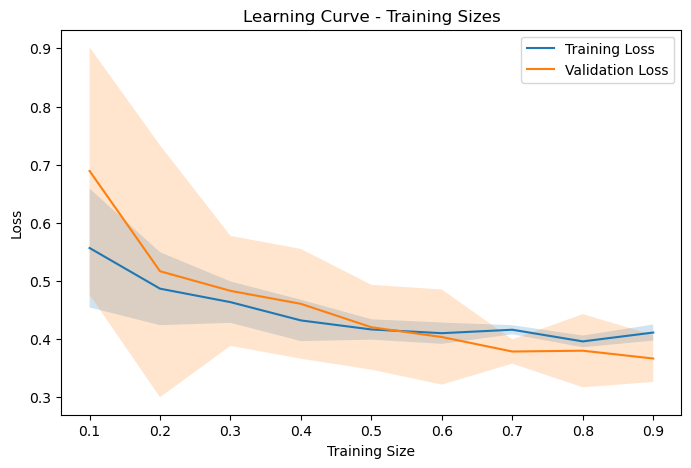

In [196]:
plt.figure(figsize=(8, 5))

plt.plot(training_sizes, [learning['history']['loss']['mean'][-1] for learning in isomap_learning_all], label='Training Loss', )
plt.plot(training_sizes, [learning['history']['val_loss']['mean'][-1] for learning in isomap_learning_all], label='Validation Loss', )

plt.fill_between(training_sizes, [learning['history']['loss']['mean'][-1] - learning['history']['loss']['std'][-1] for learning in isomap_learning_all], [learning['history']['loss']['mean'][-1] + learning['history']['loss']['std'][-1] for learning in isomap_learning_all], alpha=0.2)
plt.fill_between(training_sizes, [learning['history']['val_loss']['mean'][-1] - learning['history']['val_loss']['std'][-1] for learning in isomap_learning_all], [learning['history']['val_loss']['mean'][-1] + learning['history']['val_loss']['std'][-1] for learning in isomap_learning_all], alpha=0.2)

plt.title("Learning Curve - Training Sizes")
plt.xlabel('Training Size')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [221]:
# pd.concat([baseline_pt_results_df, pca_pt_results_df, ica_pt_results_df, rp_pt_results_df, isomap_pt_results_df], keys=titles).droplevel(1).query('(u2 == 16) & (learning_rate == 0.01)')
pd.concat([baseline_pt_results_df, pca_pt_results_df, ica_pt_results_df, rp_pt_results_df, isomap_pt_results_df], keys=titles).droplevel(1).query('(u2 == 16) & (learning_rate == 0.01)')[['loss', 'val_loss', 'auc', 'val_auc']]

,loss,val_loss,auc,val_auc
baseline,0.442250,0.382966,0.908313,0.935101
pca,0.438465,0.381808,0.910175,0.934067
ica,0.428252,0.394940,0.916111,0.932488
rp,0.466208,0.420943,0.896147,0.927897
isomap,0.414623,0.370884,0.914489,0.929647


In [222]:
from tensorflow.keras.callbacks import Callback

In [223]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

In [224]:
baseline_nnet =  create_model(X_train.shape[1], 16, 16, 0.01)

baseline_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

baseline_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

baseline_nnet_history = baseline_nnet.fit(X_train, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [baseline_nnet_time_callback],
                   verbose=0)

baseline_nnet_times = baseline_nnet_time_callback.times

In [225]:
pca_nnet =  create_model(X_train_pca.shape[1], 16, 16, 0.01)

pca_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

pca_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

pca_nnet_history = pca_nnet.fit(X_train_pca, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [pca_nnet_time_callback],
                   verbose=0)

pca_nnet_times = pca_nnet_time_callback.times

In [226]:
ica_nnet =  create_model(X_train_ica.shape[1], 16, 16, 0.01)

ica_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

ica_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

ica_nnet_history = ica_nnet.fit(X_train_ica, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [ica_nnet_time_callback],
                   verbose=0)

ica_nnet_times = ica_nnet_time_callback.times

In [227]:
# ica_subset_nnet =  create_model(X_train_ica_selected.shape[1], 16, 16, 0.01)

# ica_subset_nnet.compile(optimizer=Adam(learning_rate=0.01), 
#               loss='binary_crossentropy', 
#               metrics=['AUC'])

# ica_subset_nnet_time_callback = TimeHistory()

# early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# ica_subset_nnet_history = ica_subset_nnet.fit(X_train_ica_selected, y_train,
#                    epochs=200,
#                    batch_size=32,
#                    callbacks=[early_stopping] + [ica_subset_nnet_time_callback],
#                    verbose=0)

# ica_subset_nnet_times = ica_subset_nnet_time_callback.times

In [228]:
rp_nnet =  create_model(X_train_rp.shape[1], 16, 16, 0.01)

rp_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

rp_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

rp_nnet_history = rp_nnet.fit(X_train_rp, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [rp_nnet_time_callback],
                   verbose=0)

rp_nnet_times = rp_nnet_time_callback.times

In [229]:
isomap_nnet =  create_model(X_train_isomap.shape[1], 16, 16, 0.01)

isomap_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

isomap_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

isomap_nnet_history = isomap_nnet.fit(X_train_isomap, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [isomap_nnet_time_callback],
                   verbose=0)

isomap_nnet_times = isomap_nnet_time_callback.times

In [297]:
nnet_labels = {
    'baseline': np.round(baseline_nnet.predict(X_train, verbose=0)).astype(int).flatten(),
    'pca': np.round(pca_nnet.predict(X_train_pca, verbose=0)).astype(int).flatten(),
    'ica': np.round(ica_nnet.predict(X_train_ica, verbose=0)).astype(int).flatten(),
    # 'ica_subset': np.round(ica_subset_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': np.round(rp_nnet.predict(X_train_rp, verbose=0)).astype(int).flatten(),
    'isomap': np.round(isomap_nnet.predict(X_train_isomap, verbose=0)).astype(int).flatten(),
}

In [243]:
nnet_predictions = {
    'baseline': np.round(baseline_nnet.predict(X_test, verbose=0)).astype(int).flatten(),
    'pca': np.round(pca_nnet.predict(X_test_pca, verbose=0)).astype(int).flatten(),
    'ica': np.round(ica_nnet.predict(X_test_ica, verbose=0)).astype(int).flatten(),
    # 'ica_subset': np.round(ica_subset_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': np.round(rp_nnet.predict(X_test_rp, verbose=0)).astype(int).flatten(),
    'isomap': np.round(isomap_nnet.predict(X_test_isomap, verbose=0)).astype(int).flatten(),
}

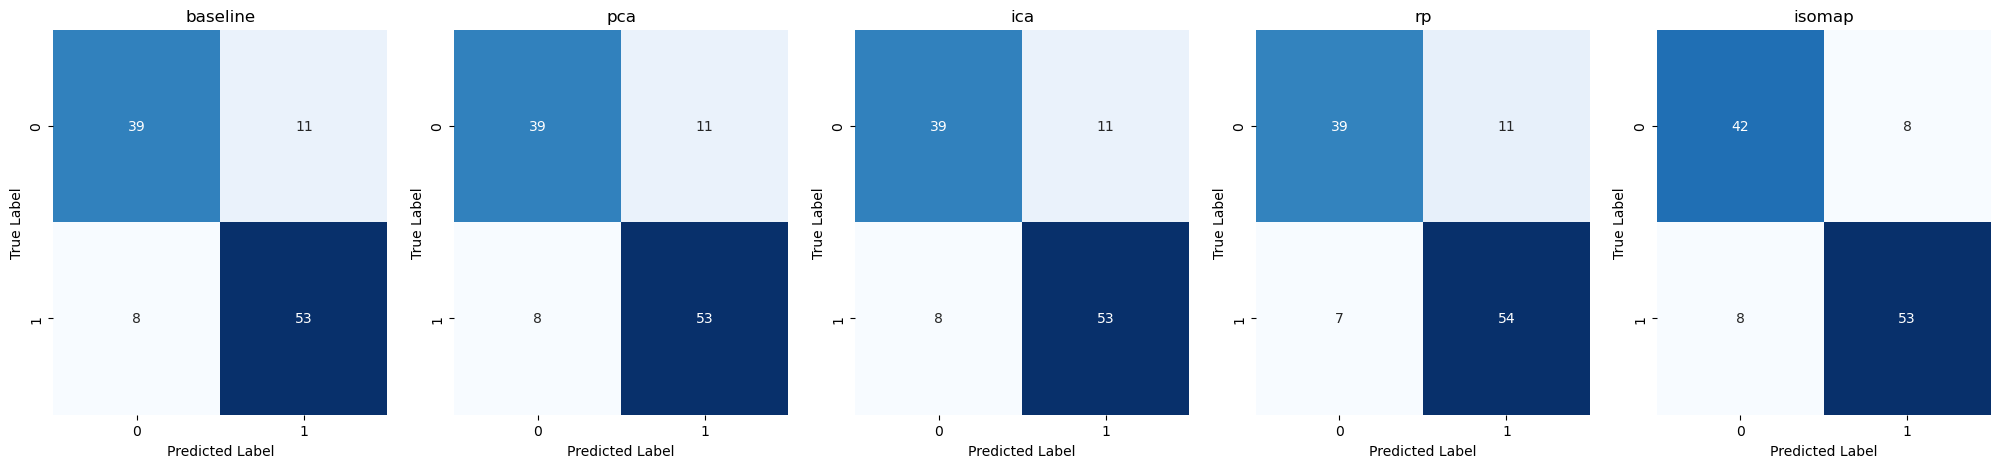

In [244]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes = axes.flatten()

for ax, k in zip(axes, nnet_predictions.keys()):
    sns.heatmap(confusion_matrix(y_test, nnet_predictions[k]), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{k}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

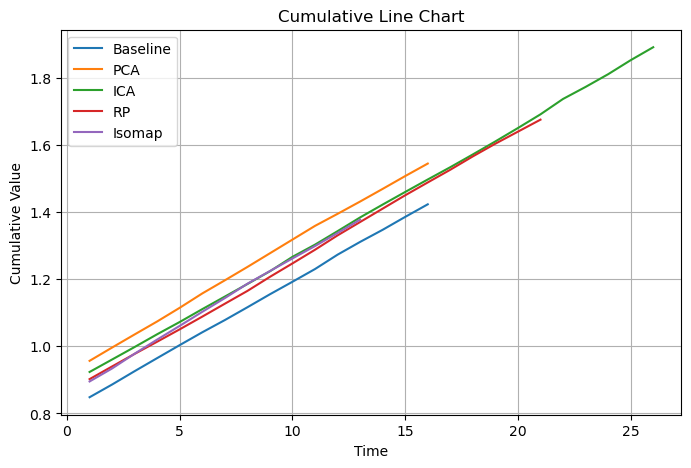

In [245]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=range(1, len(baseline_nnet_times)+1), y=np.cumsum(baseline_nnet_times), label='Baseline')
sns.lineplot(x=range(1, len(pca_nnet_times)+1), y=np.cumsum(pca_nnet_times), label='PCA')
sns.lineplot(x=range(1, len(ica_nnet_times)+1), y=np.cumsum(ica_nnet_times), label='ICA')
# sns.lineplot(x=range(1, len(ica_subset_nnet_times)+1), y=np.cumsum(ica_subset_nnet_times), label='Baseline')
sns.lineplot(x=range(1, len(rp_nnet_times)+1), y=np.cumsum(rp_nnet_times), label='RP')
sns.lineplot(x=range(1, len(isomap_nnet_times)+1), y=np.cumsum(isomap_nnet_times), label='Isomap')


# Customize the plot
plt.title('Cumulative Line Chart')
plt.xlabel('Time')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend()
plt.show()

In [246]:
nnet_times = {
    'baseline': np.sum(baseline_nnet_times),
    'pca': np.sum(pca_nnet_times),
    'ica': np.sum(ica_nnet_times),
    # 'ica_subset': np.round(ica_subset_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': np.sum(rp_nnet_times),
    'isomap': np.sum(isomap_nnet_times),
}

In [332]:
nnet_iters = {
    'baseline': len(baseline_nnet_times),
    'pca': len(pca_nnet_times),
    'ica': len(ica_nnet_times),
    # 'ica_subset': np.round(ica_subset_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': len(rp_nnet_times),
    'isomap': len(isomap_nnet_times),
}

In [333]:
pd.DataFrame(nnet_iters, index=[0])

,baseline,pca,ica,rp,isomap
0,16,16,26,21,13


In [247]:
pd.DataFrame(nnet_times, index=[0])

,baseline,pca,ica,rp,isomap
0,1.423741,1.54529,1.892299,1.676248,1.378077


In [298]:
pd.DataFrame(
    [
        {
            'Accuracy': accuracy_score(y_train, nnet_labels[clf]),
            'ROC AUC': roc_auc_score(y_train, nnet_labels[clf]),
            'Precision': precision_score(y_train, nnet_labels[clf]),
            'Recall': recall_score(y_train, nnet_labels[clf]),
            'F1 Score': f1_score(y_train, nnet_labels[clf]),
        }
        
        for clf in nnet_labels.keys()
    ],
    index=list(nnet_labels.keys())
) # .style.highlight_max(color='lightgreen', axis=0)

,Accuracy,ROC AUC,Precision,Recall,F1 Score
baseline,0.879802,0.873117,0.860082,0.935123,0.896034
pca,0.881041,0.878831,0.887417,0.899329,0.893333
ica,0.887237,0.881180,0.869295,0.937360,0.902045
rp,0.855019,0.846150,0.830000,0.928412,0.876452
isomap,0.871128,0.867720,0.872017,0.899329,0.885463


In [248]:
pd.DataFrame(
    [
        {
            'Accuracy': accuracy_score(y_test, nnet_predictions[clf]),
            'ROC AUC': roc_auc_score(y_test, nnet_predictions[clf]),
            'Precision': precision_score(y_test, nnet_predictions[clf]),
            'Recall': recall_score(y_test, nnet_predictions[clf]),
            'F1 Score': f1_score(y_test, nnet_predictions[clf]),
        }
        
        for clf in nnet_predictions.keys()
    ],
    index=list(nnet_predictions.keys())
) # .style.highlight_max(color='lightgreen', axis=0)

,Accuracy,ROC AUC,Precision,Recall,F1 Score
baseline,0.828829,0.824426,0.828125,0.868852,0.848000
pca,0.828829,0.824426,0.828125,0.868852,0.848000
ica,0.828829,0.824426,0.828125,0.868852,0.848000
rp,0.837838,0.832623,0.830769,0.885246,0.857143
isomap,0.855856,0.854426,0.868852,0.868852,0.868852


### NNet with Clustering Results

In [264]:
c_X_train = pd.concat(
    [
        pd.DataFrame(X_train),
        pd.get_dummies(pd.Series(red_clustering_model_data['kmeans']['baseline']['labels']), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(red_clustering_model_data['gmm']['baseline']['labels']), prefix='em_label').astype(int)
    ],
    axis=1
)

In [265]:
c_X_train_pca = pd.concat(
    [
        pd.DataFrame(X_train_pca),
        pd.get_dummies(pd.Series(red_clustering_model_data['kmeans']['pca']['labels']), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(red_clustering_model_data['gmm']['pca']['labels']), prefix='em_label').astype(int)
    ],
    axis=1
)

In [266]:
pca_c_nnet =  create_model(c_X_train_pca.shape[1], 16, 16, 0.01)

pca_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

pca_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

pca_c_nnet_history = pca_c_nnet.fit(c_X_train_pca, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [pca_c_nnet_time_callback],
                   verbose=0)

pca_c_nnet_times = pca_c_nnet_time_callback.times

In [267]:
c_X_train_ica = pd.concat(
    [
        pd.DataFrame(X_train_ica),
        pd.get_dummies(pd.Series(red_clustering_model_data['kmeans']['ica']['labels']), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(red_clustering_model_data['gmm']['ica']['labels']), prefix='em_label').astype(int)
    ],
    axis=1
)

In [268]:
ica_c_nnet =  create_model(c_X_train_ica.shape[1], 16, 16, 0.01)

ica_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

ica_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

ica_c_nnet_history = ica_c_nnet.fit(c_X_train_ica, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [ica_c_nnet_time_callback],
                   verbose=0)

ica_c_nnet_times = ica_c_nnet_time_callback.times

In [269]:
c_X_train_rp = pd.concat(
    [
        pd.DataFrame(X_train_rp),
        pd.get_dummies(pd.Series(red_clustering_model_data['kmeans']['rp']['labels']), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(red_clustering_model_data['gmm']['rp']['labels']), prefix='em_label').astype(int)
    ],
    axis=1
)

In [270]:
rp_c_nnet =  create_model(c_X_train_rp.shape[1], 16, 16, 0.01)

rp_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

rp_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

rp_c_nnet_history = rp_c_nnet.fit(c_X_train_rp, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [rp_c_nnet_time_callback],
                   verbose=0)

rp_c_nnet_times = rp_c_nnet_time_callback.times

In [271]:
c_X_train_isomap = pd.concat(
    [
        pd.DataFrame(X_train_isomap),
        pd.get_dummies(pd.Series(red_clustering_model_data['kmeans']['isomap']['labels']), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(red_clustering_model_data['gmm']['isomap']['labels']), prefix='em_label').astype(int)
    ],
    axis=1
)

In [272]:
isomap_c_nnet =  create_model(c_X_train_isomap.shape[1], 16, 16, 0.01)

isomap_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

isomap_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

isomap_c_nnet_history = isomap_c_nnet.fit(c_X_train_isomap, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [isomap_c_nnet_time_callback],
                   verbose=0)

isomap_c_nnet_times = isomap_c_nnet_time_callback.times

In [274]:
c_X_test = pd.concat(
    [
        pd.DataFrame(X_test),
        pd.get_dummies(pd.Series(kmeans.predict(pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out()))), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(gmm.predict(pd.DataFrame(X_test, columns=preprocessor.get_feature_names_out()))), prefix='em_label').astype(int)
    ],
    axis=1
)

In [276]:
c_X_test_pca = pd.concat(
    [
        pd.DataFrame(X_test_pca),
        pd.get_dummies(pd.Series(kmeans_pca.predict(pd.DataFrame(X_test_pca, columns=[f'Component {i}' for i in range(1, X_test_pca.shape[1]+1)]))), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(gmm_pca.predict(pd.DataFrame(X_test_pca, columns=[f'Component {i}' for i in range(1, X_test_pca.shape[1]+1)]))), prefix='em_label').astype(int)
    ],
    axis=1
)

In [277]:
c_X_test_ica = pd.concat(
    [
        pd.DataFrame(X_test_ica),
        pd.get_dummies(pd.Series(kmeans_ica.predict(pd.DataFrame(X_test_ica, columns=[f'Component {i}' for i in range(1, X_test_ica.shape[1]+1)]))), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(gmm_ica.predict(pd.DataFrame(X_test_ica, columns=[f'Component {i}' for i in range(1, X_test_ica.shape[1]+1)]))), prefix='em_label').astype(int)
    ],
    axis=1
)

In [278]:
c_X_test_rp = pd.concat(
    [
        pd.DataFrame(X_test_rp),
        pd.get_dummies(pd.Series(kmeans_rp.predict(pd.DataFrame(X_test_rp, columns=[f'Component {i}' for i in range(1, X_test_rp.shape[1]+1)]))), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(gmm_rp.predict(pd.DataFrame(X_test_rp, columns=[f'Component {i}' for i in range(1, X_test_rp.shape[1]+1)]))), prefix='em_label').astype(int)
    ],
    axis=1
)

In [279]:
c_X_test_isomap = pd.concat(
    [
        pd.DataFrame(X_test_isomap),
        pd.get_dummies(pd.Series(kmeans_isomap.predict(pd.DataFrame(X_test_isomap, columns=[f'Component {i}' for i in range(1, X_test_isomap.shape[1]+1)]))), prefix='km_label').astype(int),
        pd.get_dummies(pd.Series(gmm_isomap.predict(pd.DataFrame(X_test_isomap, columns=[f'Component {i}' for i in range(1, X_test_isomap.shape[1]+1)]))), prefix='em_label').astype(int)
    ],
    axis=1
)

In [281]:
baseline_c_nnet =  create_model(c_X_train.shape[1], 16, 16, 0.01)

baseline_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

baseline_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

baseline_c_nnet_history = baseline_c_nnet.fit(c_X_train, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [baseline_c_nnet_time_callback],
                   verbose=0)

baseline_c_nnet_times = baseline_c_nnet_time_callback.times

In [289]:
pca_c_nnet =  create_model(c_X_train_pca.shape[1], 16, 16, 0.01)

pca_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

pca_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

pca_c_nnet_history = pca_c_nnet.fit(c_X_train_pca, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [pca_c_nnet_time_callback],
                   verbose=0)

pca_c_nnet_times = pca_c_nnet_time_callback.times

In [283]:
ica_c_nnet =  create_model(c_X_train_ica.shape[1], 16, 16, 0.01)

ica_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

ica_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

ica_c_nnet_history = ica_c_nnet.fit(c_X_train_ica, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [ica_c_nnet_time_callback],
                   verbose=0)

ica_c_nnet_times = ica_c_nnet_time_callback.times

In [284]:
rp_c_nnet =  create_model(c_X_train_rp.shape[1], 16, 16, 0.01)

rp_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

rp_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

rp_c_nnet_history = rp_c_nnet.fit(c_X_train_rp, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [rp_c_nnet_time_callback],
                   verbose=0)

rp_c_nnet_times = rp_c_nnet_time_callback.times

In [285]:
isomap_c_nnet =  create_model(c_X_train_isomap.shape[1], 16, 16, 0.01)

isomap_c_nnet.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['AUC'])

isomap_c_nnet_time_callback = TimeHistory()

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

isomap_c_nnet_history = isomap_c_nnet.fit(c_X_train_isomap, y_train,
                   epochs=200,
                   batch_size=32,
                   callbacks=[early_stopping] + [isomap_c_nnet_time_callback],
                   verbose=0)

isomap_c_nnet_times = isomap_c_nnet_time_callback.times

In [299]:
c_nnet_labels = {
    'baseline': np.round(baseline_c_nnet.predict(c_X_train, verbose=0)).astype(int).flatten(),
    'pca': np.round(pca_c_nnet.predict(c_X_train_pca, verbose=0)).astype(int).flatten(),
    'ica': np.round(ica_c_nnet.predict(c_X_train_ica, verbose=0)).astype(int).flatten(),
    'rp': np.round(rp_c_nnet.predict(c_X_train_rp, verbose=0)).astype(int).flatten(),
    'isomap': np.round(isomap_c_nnet.predict(c_X_train_isomap, verbose=0)).astype(int).flatten(),
}

In [290]:
c_nnet_predictions = {
    'baseline': np.round(baseline_c_nnet.predict(c_X_test, verbose=0)).astype(int).flatten(),
    'pca': np.round(pca_c_nnet.predict(c_X_test_pca, verbose=0)).astype(int).flatten(),
    'ica': np.round(ica_c_nnet.predict(c_X_test_ica, verbose=0)).astype(int).flatten(),
    # 'ica_subset': np.round(ica_subset_c_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': np.round(rp_c_nnet.predict(c_X_test_rp, verbose=0)).astype(int).flatten(),
    'isomap': np.round(isomap_c_nnet.predict(c_X_test_isomap, verbose=0)).astype(int).flatten(),
}

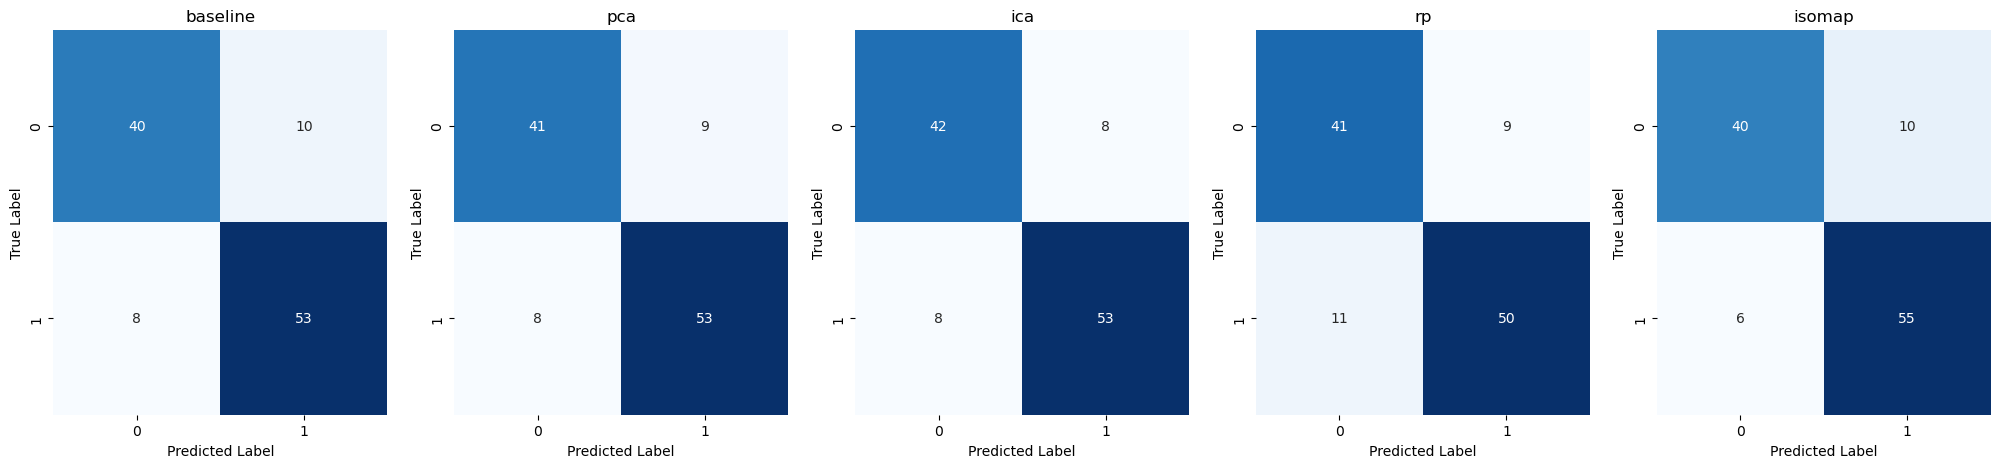

In [291]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes = axes.flatten()

for ax, k in zip(axes, c_nnet_predictions.keys()):
    sns.heatmap(confusion_matrix(y_test, c_nnet_predictions[k]), annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{k}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

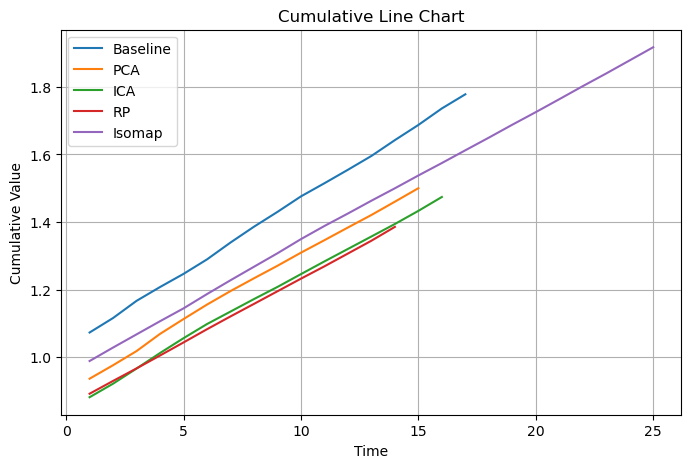

In [292]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=range(1, len(baseline_c_nnet_times)+1), y=np.cumsum(baseline_c_nnet_times), label='Baseline')
sns.lineplot(x=range(1, len(pca_c_nnet_times)+1), y=np.cumsum(pca_c_nnet_times), label='PCA')
sns.lineplot(x=range(1, len(ica_c_nnet_times)+1), y=np.cumsum(ica_c_nnet_times), label='ICA')
# sns.lineplot(x=range(1, len(ica_subset_c_nnet_times)+1), y=np.cumsum(ica_subset_c_nnet_times), label='Baseline')
sns.lineplot(x=range(1, len(rp_c_nnet_times)+1), y=np.cumsum(rp_c_nnet_times), label='RP')
sns.lineplot(x=range(1, len(isomap_c_nnet_times)+1), y=np.cumsum(isomap_c_nnet_times), label='Isomap')


# Customize the plot
plt.title('Cumulative Line Chart')
plt.xlabel('Time')
plt.ylabel('Cumulative Value')
plt.grid(True)
plt.legend()
plt.show()

In [293]:
c_nnet_times = {
    'baseline': np.sum(baseline_c_nnet_times),
    'pca': np.sum(pca_c_nnet_times),
    'ica': np.sum(ica_c_nnet_times),
    # 'ica_subset': np.round(ica_subset_c_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': np.sum(rp_c_nnet_times),
    'isomap': np.sum(isomap_c_nnet_times),
}

In [294]:
pd.DataFrame(c_nnet_times, index=[0])

,baseline,pca,ica,rp,isomap
0,1.778062,1.500262,1.474302,1.385896,1.91729


In [330]:
c_nnet_iters = {
    'baseline': len(baseline_c_nnet_times),
    'pca': len(pca_c_nnet_times),
    'ica': len(ica_c_nnet_times),
    # 'ica_subset': np.round(ica_subset_c_nnet.predict(X_test_ica_selected, verbose=0)).astype(int).flatten(),
    'rp': len(rp_c_nnet_times),
    'isomap': len(isomap_c_nnet_times),
}

In [331]:
pd.DataFrame(c_nnet_iters, index=[0])

,baseline,pca,ica,rp,isomap
0,17,15,16,14,25


In [301]:
pd.DataFrame(
    [
        {
            'Accuracy': accuracy_score(y_train, c_nnet_labels[clf]),
            'ROC AUC': roc_auc_score(y_train, c_nnet_labels[clf]),
            'Precision': precision_score(y_train, c_nnet_labels[clf]),
            'Recall': recall_score(y_train, c_nnet_labels[clf]),
            'F1 Score': f1_score(y_train, c_nnet_labels[clf]),
        }
        
        for clf in c_nnet_labels.keys()
    ],
    index=list(c_nnet_labels.keys())
) # .style.highlight_max(color='lightgreen', axis=0)

,Accuracy,ROC AUC,Precision,Recall,F1 Score
baseline,0.881041,0.878290,0.884026,0.903803,0.893805
pca,0.882280,0.879409,0.884279,0.906040,0.895028
ica,0.869888,0.868494,0.883408,0.881432,0.882419
rp,0.857497,0.858660,0.889671,0.847875,0.868270
isomap,0.878563,0.871188,0.855397,0.939597,0.895522


In [295]:
pd.DataFrame(
    [
        {
            'Accuracy': accuracy_score(y_test, c_nnet_predictions[clf]),
            'ROC AUC': roc_auc_score(y_test, c_nnet_predictions[clf]),
            'Precision': precision_score(y_test, c_nnet_predictions[clf]),
            'Recall': recall_score(y_test, c_nnet_predictions[clf]),
            'F1 Score': f1_score(y_test, c_nnet_predictions[clf]),
        }
        
        for clf in c_nnet_predictions.keys()
    ],
    index=list(c_nnet_predictions.keys())
) # .style.highlight_max(color='lightgreen', axis=0)

,Accuracy,ROC AUC,Precision,Recall,F1 Score
baseline,0.837838,0.834426,0.841270,0.868852,0.854839
pca,0.846847,0.844426,0.854839,0.868852,0.861789
ica,0.855856,0.854426,0.868852,0.868852,0.868852
rp,0.819820,0.819836,0.847458,0.819672,0.833333
isomap,0.855856,0.850820,0.846154,0.901639,0.873016
